In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install deap
!pip install alibi[tensorflow]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 k

In [1]:
import os
os.chdir("/content/drive/MyDrive/WORK/Meta_Explainer/Meta-Explainer")
import sys
sys.path.append('/content/drive/MyDrive/WORK/Meta_Explainer/Meta-Explainer')
sys.path

['/content',
 '/env/python',
 '/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/usr/local/lib/python3.11/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.11/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/WORK/Meta_Explainer/Meta-Explainer']

In [30]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.applications.vgg16 as vgg16
from tensorflow.keras.preprocessing import image

from skimage.color import gray2rgb, rgb2gray, label2rgb

from alibi.explainers import CEM
from alibi.explainers import Counterfactual
from alibi.explainers import CounterfactualProto
import time
tf.compat.v1.disable_eager_execution()

from aux_functions import load_explanations_from_pkl, save_explanations_to_pkl
from Metrics.Counterfactual_Metrics import calculate_implausibility, calculate_proximity, calculate_feasibility, calculate_discriminative_power, calculate_sparsity

#Reading Data and Model (MNIST)

In [3]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# For use with Lime and Shap
x_train_rgb = np.stack([gray2rgb(img) for img in x_train], axis=0)
x_test_rgb = np.stack([gray2rgb(img) for img in x_test], axis=0)

# Convert to Keras-compatible format (add channel dimension for RGB images)
x_train_rgb = x_train_rgb[..., np.newaxis].reshape(-1, 28, 28, 3)
x_test_rgb = x_test_rgb[..., np.newaxis].reshape(-1, 28, 28, 3)

# Preprocess the data
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

11490434/11490434 [==============================] - 0s 0us/step


In [9]:
# Load model and weights separately
loaded_model = keras.models.load_model("Images/Model/mnist_model_architecture.h5")
loaded_model.load_weights("Images/Model/mnist_model_weights.h5")

#Instance Selection (MNIST)

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


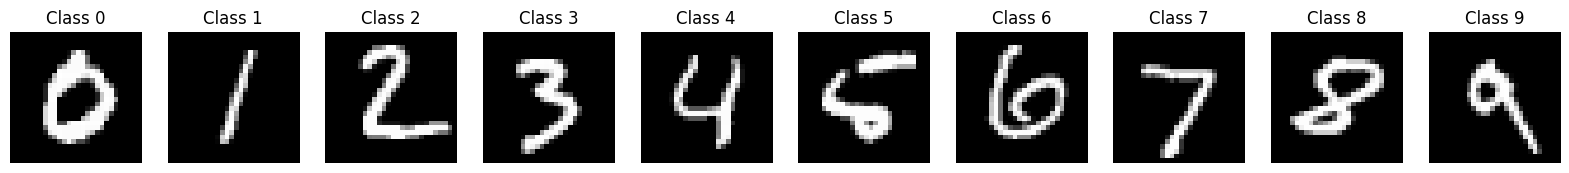

In [10]:
# Function to select a correctly classified image for each class
def select_correctly_classified_images(x_test, y_test, model):
    selected_images = []
    selected_labels = []

    for i in range(10):  # Iterate through all classes (0-9)
        # Get the indices of images belonging to class i
        indices = np.where(y_test == i)[0]

        for idx in indices:
            image = x_test[idx]
            label = y_test[idx]
            # Predict the class using the model
            prediction = np.argmax(model.predict(image[np.newaxis, ...]), axis=1)[0]

            if prediction == label:
                selected_images.append(image)
                selected_labels.append(label)
                break  # Move to the next class once a correctly classified image is selected

    return np.array(selected_images), np.array(selected_labels)

# Select one correctly classified image per class
x_selected, y_selected = select_correctly_classified_images(x_test, y_test, loaded_model)
x_selected_rgb = np.stack([gray2rgb(img) for img in x_selected], axis=0)

# Visualize the selected images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_selected[i].squeeze(), cmap='gray')
    plt.title(f'Class {y_selected[i]}')
    plt.axis('off')
plt.show()

In [6]:
predictions = [np.argmax(loaded_model.predict(np.expand_dims(image, axis=0))) for image in x_selected]
predictions

1/1 [==============================] - 0s 18ms/step


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

#Individual Explanations (Alibi Explain)

###CEM

In [12]:
# Parameters for CEM (Contrastive Explanation Method)
# Define the explanation type: 'PN' for Pertinent Negatives
mode = 'PN'

# Shape of instances: (1,) for batch size + shape of training features
shape = (1,) + x_train.shape[1:]

# Minimum difference between the probability of the original class and the maximum probability of other classes
kappa = 0.0

# Weight of the L1 loss (minimizes changes in features)
beta = 0.1

# Weight of the optional loss term to maintain consistency with the distribution (if using an autoencoder)
gamma = 100

# Initial weight of the loss that encourages changing the model's prediction
c_init = 1.0

# Number of steps to update c (adjusts the importance of the prediction loss)
c_steps = 10

# Maximum number of iterations for each value of c
max_iterations = 1000

# Valid range of values for the features
feature_range = (x_train.min(), x_train.max())

# Clipping range for gradients during optimization
clip = (-1000.0, 1000.0)

# Initial learning rate for the optimizer
lr_init = 1e-2

# Background value that contains no information (e.g., black for MNIST images)
no_info_val = -1.0

In [13]:
# Initialize the CEM explainer with the defined parameters
cem_explainer = CEM(
    loaded_model,  # The loaded model
    mode=mode,
    shape=shape,
    kappa=kappa,
    beta=beta,
    gamma=gamma,
    c_init=c_init,
    c_steps=c_steps,
    max_iterations=max_iterations,
    feature_range=feature_range,
    learning_rate_init=lr_init,
    clip=clip,
    no_info_val=no_info_val,
    ae_model=None  # No autoencoder is used in this case
)

In [14]:
# Fit the explainer to the training data
cem_explainer.fit(x_train, no_info_type='median')  # Median is considered as "no information"

CEM(meta={
  'name': 'CEM',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'mode': 'PN',
              'shape': (1, 28, 28, 1),
              'kappa': 0.0,
              'beta': 0.1,
              'feature_range': (0.0, 1.0),
              'gamma': 100,
              'learning_rate_init': 0.01,
              'max_iterations': 1000,
              'c_init': 1.0,
              'c_steps': 10,
              'eps': (0.001, 0.001),
              'clip': (-1000.0, 1000.0),
              'update_num_grad': 1,
              'no_info_val': -1.0,
              'write_dir': None,
              'is_model': True,
              'is_ae': False,
              'no_info_type': 'median'}
            ,
  'version': '0.9.6'}
)

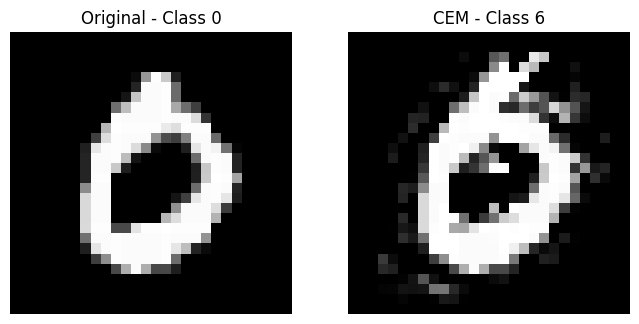

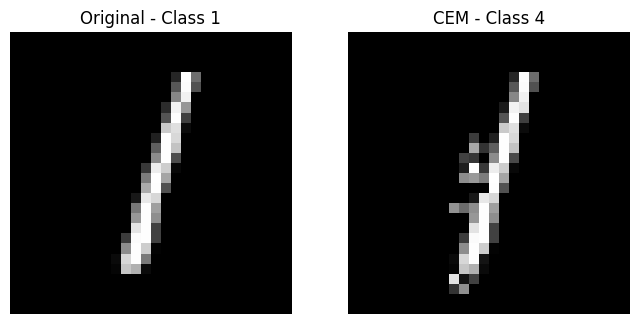

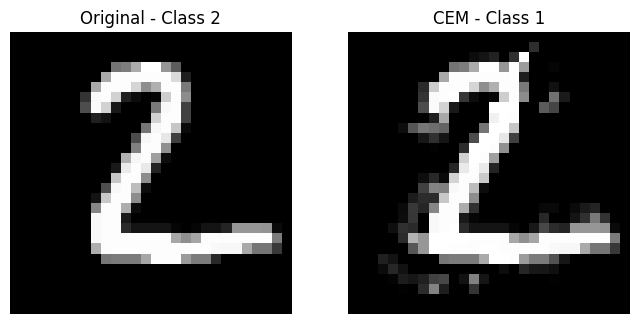

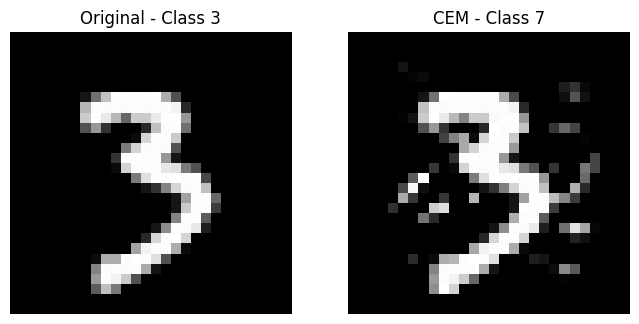

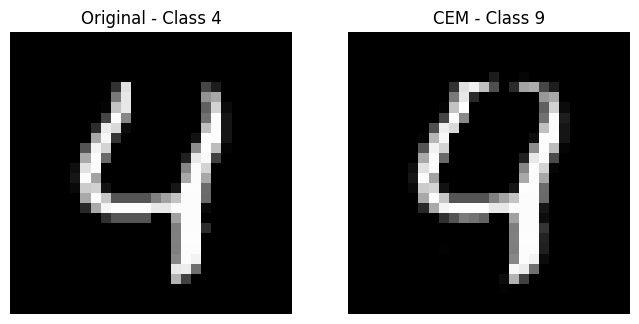

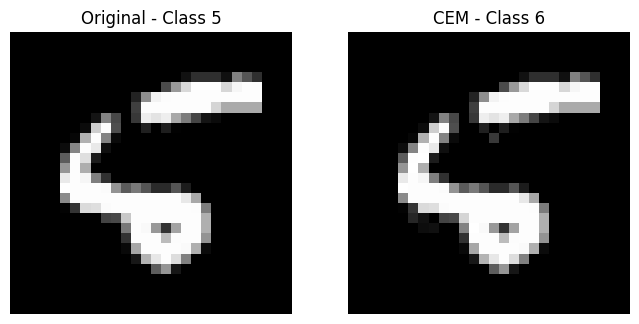

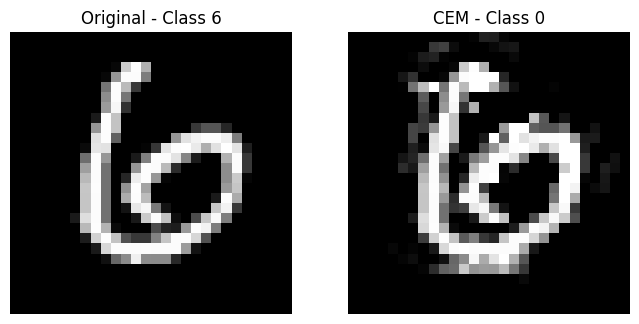

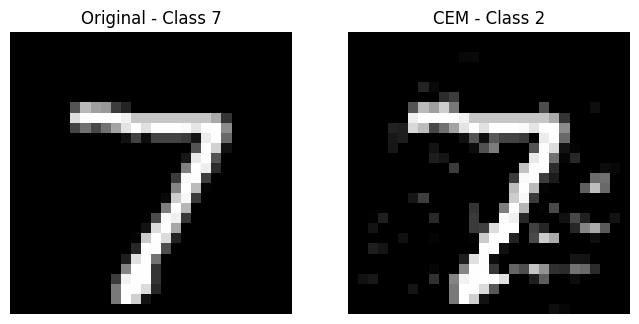

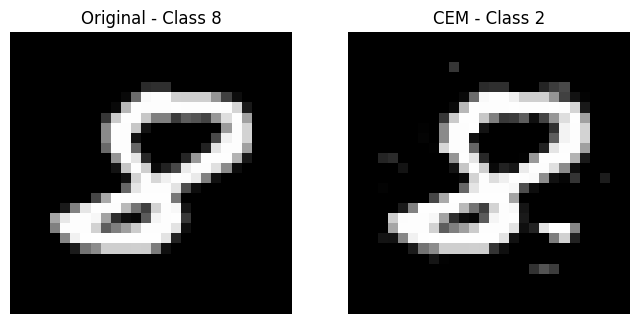

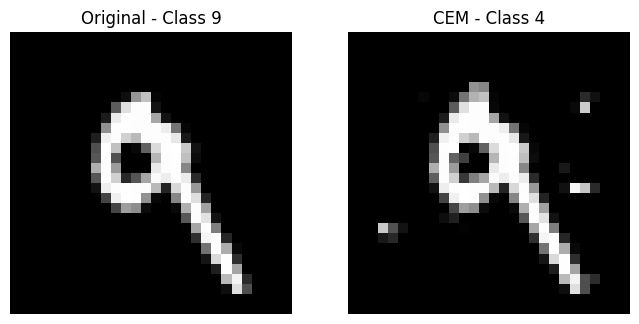

FileNotFoundError: [Errno 2] No such file or directory: 'Images/Countefactual/explanations_pkl/conterfactuals_cem.pkl'

In [15]:
### **CEM**
cem_explanations = []

for i, image in enumerate(x_selected):
    X = image.reshape((1,) + image.shape)
    explanation = cem_explainer.explain(X)

    # Save explanation data
    explanation_data = {
        'method': 'CEM',
        'original_class': y_selected[i],
        'original_image': image,
        'cf_class': explanation.PN_pred,
        'cf_image': explanation.PN,
    }

    cem_explanations.append(explanation_data)

    # Plot the original image and the counterfactual
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Original - Class {y_selected[i]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(explanation.PN.squeeze(), cmap='gray')
    plt.title(f"CEM - Class {explanation.PN_pred}")
    plt.axis('off')
    plt.show()

In [22]:
# Save CEM explanations
save_explanations_to_pkl(cem_explanations, 'Images/Counterfactual/explanations_pkl/conterfactuals_cem.pkl')

Explanations saved to Images/Counterfactual/explanations_pkl/conterfactuals_cem.pkl
CEM explanations successfully saved to: Images/Countefactual/explanations_pkl/conterfactuals_cem.pkl


##CF

In [23]:
# Configure the selected images (assuming you already have `x_selected` and `x_train`)
# `x_selected` are the images you selected for explanation, and `x_train` is the training dataset.

# Set parameters for the Counterfactual method
shape = (1,) + x_train.shape[1:]  # Shape of the selected images
target_proba = 1.0                # Target probability for the target class
tol = 0.01                        # Probability tolerance to accept the counterfactual
# target_class = 'other'            # Target class, 'other' means any class different from the current prediction
max_iter = 1000                   # Maximum number of iterations
lam_init = 1e-1                   # Initial value of lambda for regularization
max_lam_steps = 10                # Maximum number of lambda adjustment steps
learning_rate_init = 0.1          # Initial learning rate
feature_range = (x_train.min(), x_train.max())  # Allowed range of values for the features

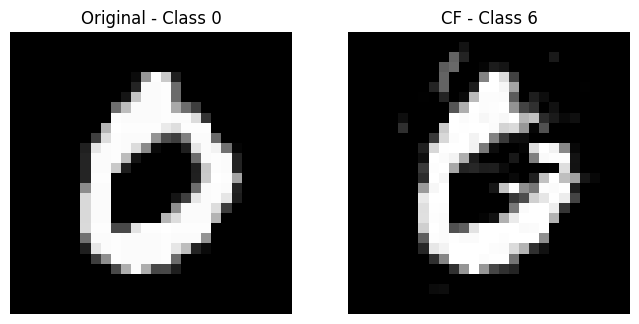

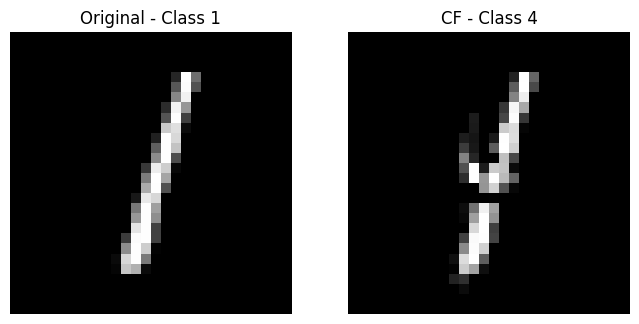

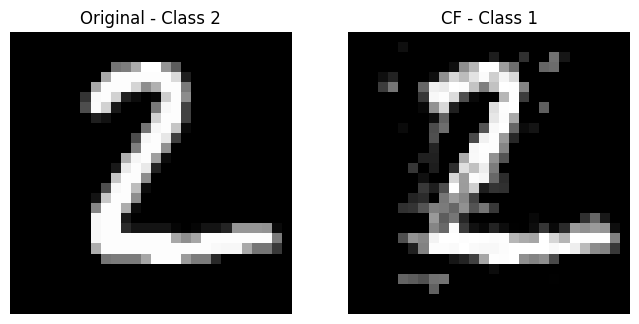

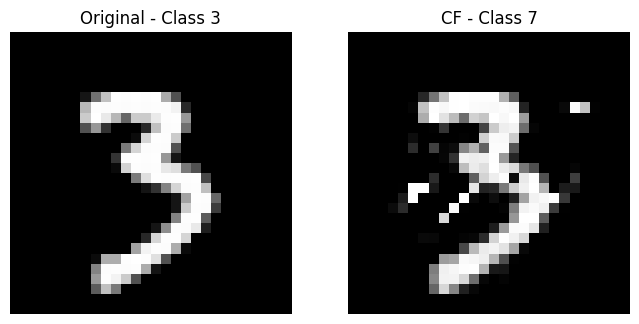

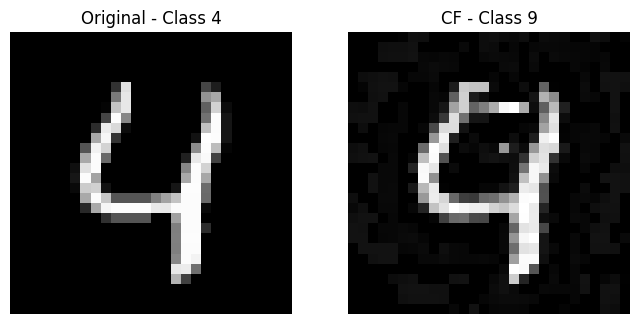

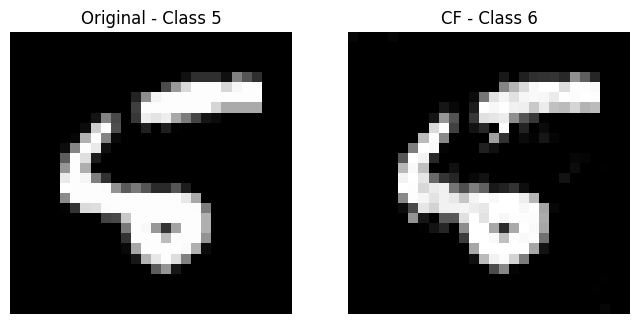

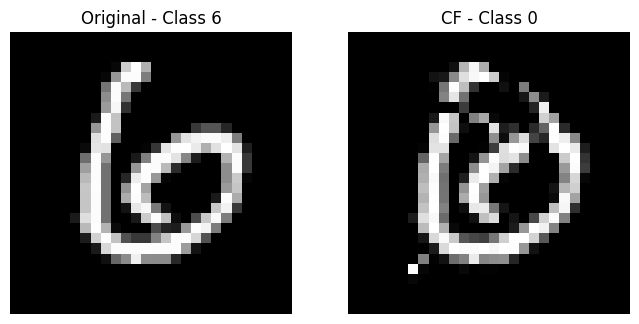

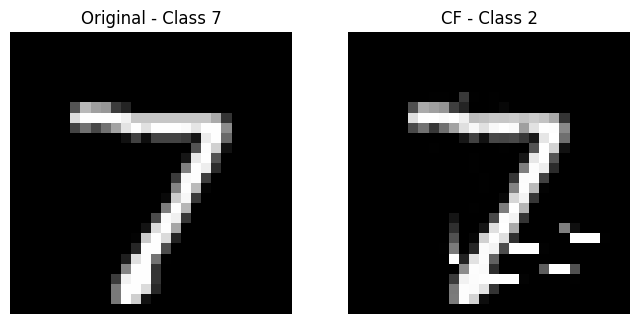

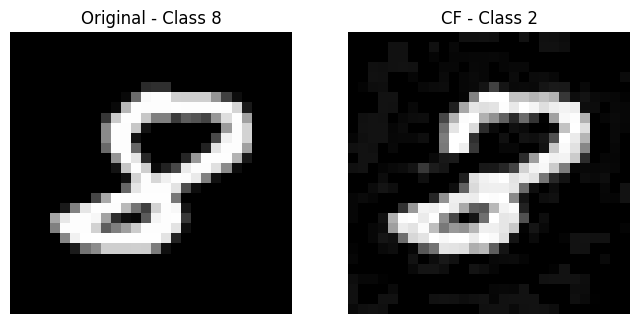

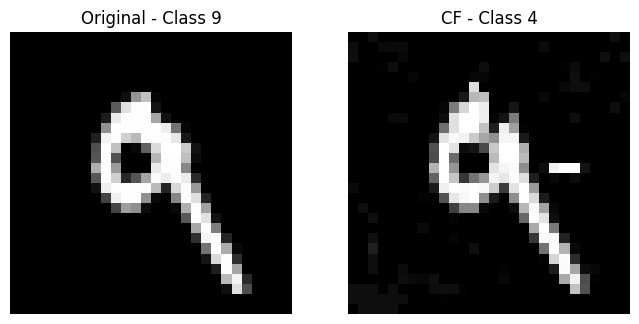

CF explanations successfully saved to: /content/drive/MyDrive/WORK/Meta_Explainer/conterfactuals_cf.pkl


In [24]:
### **CF (Counterfactual)**
cf_explanations = []

for idx, image in enumerate(x_selected):
    # Reshape the image for the model
    X = image.reshape((1,) + image.shape)

    cem_target_class = cem_explanations[idx]['cf_class']

    # Initialize the Counterfactual explainer
    cf = Counterfactual(
        loaded_model,  # Loaded model
        shape=shape,
        target_proba=target_proba,
        tol=tol,
        target_class=cem_target_class,
        max_iter=max_iter,
        lam_init=lam_init,
        max_lam_steps=max_lam_steps,
        learning_rate_init=learning_rate_init,
        feature_range=feature_range
    )

    # Generate counterfactual explanation
    explanation = cf.explain(X)

    # Save explanation data
    explanation_data = {
       'method': 'CF',
       'original_class': y_selected[idx],
       'original_image': image,
       'cf_class': explanation.cf['class'],
       'cf_image': explanation.cf['X'],
       'cf_proba': explanation.cf['proba'][0][explanation.cf['class']],
       'proto_class': None  # Not applicable for CF
    }

    cf_explanations.append(explanation_data)

    # Plot the original image and the counterfactual
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Original - Class {y_selected[idx]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(explanation.cf['X'].reshape(28, 28), cmap='gray')
    plt.title(f"CF - Class {explanation.cf['class']}")
    plt.axis('off')
    plt.show()

In [25]:
# Save CF explanations
save_explanations_to_pkl(cf_explanations, 'Images/Counterfactual/explanations_pkl/cf_explanations.pkl')

Explanations saved to Images/Counterfactual/explanations_pkl/cf_explanations.pkl


# Reading Explanations

In [31]:
# Cargar las explicaciones CEM
cem_explanations = load_explanations_from_pkl('Images/Counterfactual/explanations_pkl/conterfactuals_cem.pkl')
# Cargar las explicaciones CF
cf_explanations = load_explanations_from_pkl('Images/Counterfactual/explanations_pkl/cf_explanations.pkl')

Explanations loaded from Images/Counterfactual/explanations_pkl/conterfactuals_cem.pkl
Explanations loaded from Images/Counterfactual/explanations_pkl/cf_explanations.pkl


# Generation and Integration of Rankings

##Evaluation of the counterfactuals


Evaluating original image #1
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 6
Number of instances in the same class (6): 958
Minimum normalized distance: 0.5212537958465921

Normalized minimum distances for all counterfactuals: [0.5212537958465921]
Calculating proximity...

Counterfactual #1
Original instance #1
Normalized distance between counterfactual and original instance: 0.3874169218510921

Normalized distances for all counterfactuals relative to originals: [0.3874169218510921]
Calculating feasibility...

Counterfactual #1
Feasibility: 6.4130
Calculating discriminative power...

Counterfactual #1
Predicted class for counterfactual: 6
Discriminative power: 8.0184
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 6
Number of instances in the same class (6): 958
Minimum normalized distance: 0.4846452264990656

Normalized minimum distances for all counterfactuals: [0.4846452264990656]
Calculating proximity...



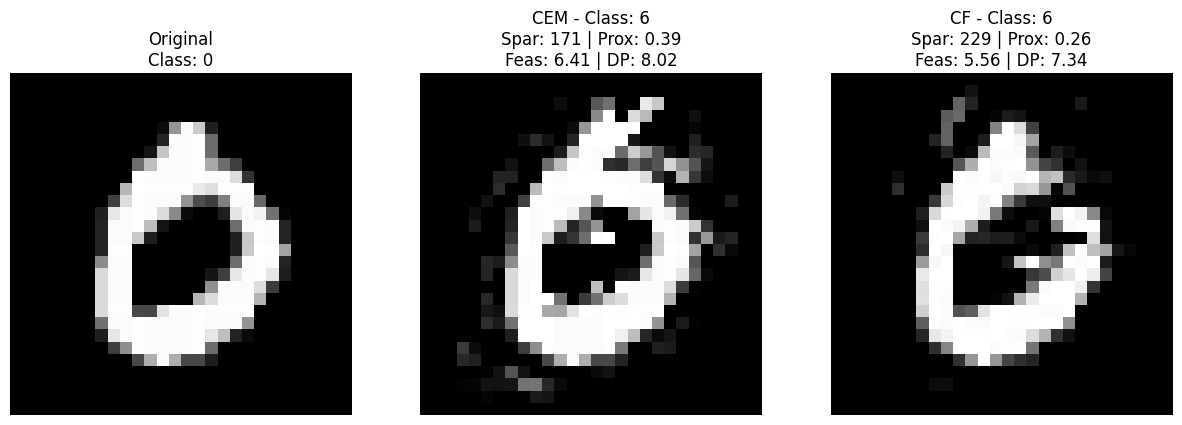


Evaluating original image #2
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 4
Number of instances in the same class (4): 982
Minimum normalized distance: 0.3860696337965953

Normalized minimum distances for all counterfactuals: [0.3860696337965953]
Calculating proximity...

Counterfactual #1
Original instance #1
Normalized distance between counterfactual and original instance: 0.39390465824293364

Normalized distances for all counterfactuals relative to originals: [0.39390465824293364]
Calculating feasibility...

Counterfactual #1
Feasibility: 2.6085
Calculating discriminative power...

Counterfactual #1
Predicted class for counterfactual: 4
Discriminative power: 5.8708
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 4
Number of instances in the same class (4): 982
Minimum normalized distance: 0.39997025964610533

Normalized minimum distances for all counterfactuals: [0.39997025964610533]
Calculating proximity.

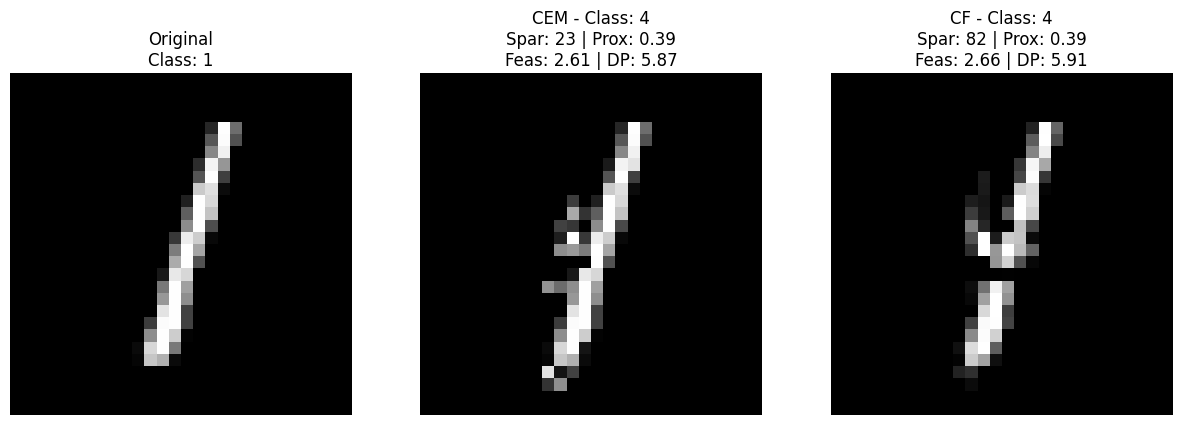


Evaluating original image #3
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 1
Number of instances in the same class (1): 1135
Minimum normalized distance: 0.7155817467100047

Normalized minimum distances for all counterfactuals: [0.7155817467100047]
Calculating proximity...

Counterfactual #1
Original instance #1
Normalized distance between counterfactual and original instance: 0.2816880601556435

Normalized distances for all counterfactuals relative to originals: [0.2816880601556435]
Calculating feasibility...

Counterfactual #1
Feasibility: 5.7814
Calculating discriminative power...

Counterfactual #1
Predicted class for counterfactual: 1
Discriminative power: 9.1143
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 1
Number of instances in the same class (1): 1135
Minimum normalized distance: 0.6640249365198232

Normalized minimum distances for all counterfactuals: [0.6640249365198232]
Calculating proximity...

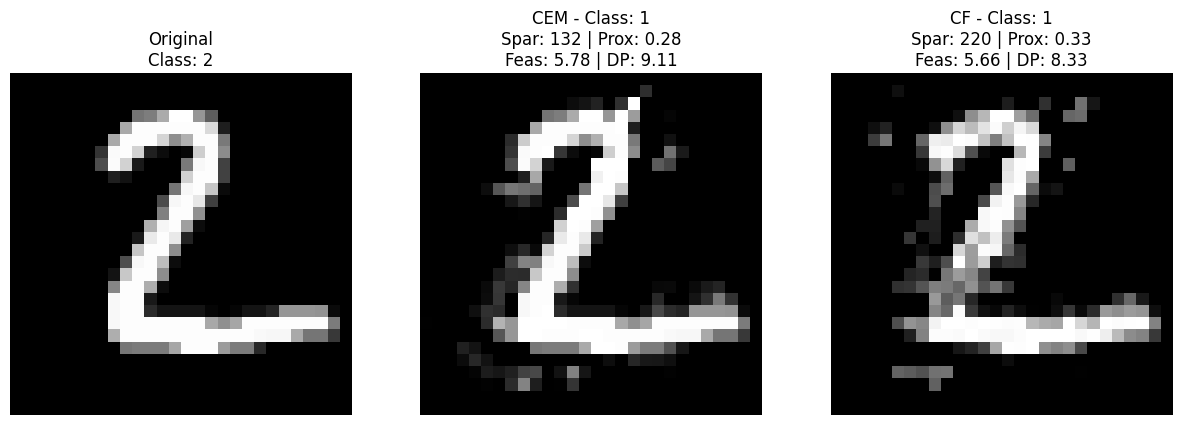


Evaluating original image #4
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 7
Number of instances in the same class (7): 1028
Minimum normalized distance: 0.5728325959228011

Normalized minimum distances for all counterfactuals: [0.5728325959228011]
Calculating proximity...

Counterfactual #1
Original instance #1
Normalized distance between counterfactual and original instance: 0.3506839098956991

Normalized distances for all counterfactuals relative to originals: [0.3506839098956991]
Calculating feasibility...

Counterfactual #1
Feasibility: 5.6385
Calculating discriminative power...

Counterfactual #1
Predicted class for counterfactual: 7
Discriminative power: 8.0525
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 7
Number of instances in the same class (7): 1028
Minimum normalized distance: 0.5408931882916062

Normalized minimum distances for all counterfactuals: [0.5408931882916062]
Calculating proximity...

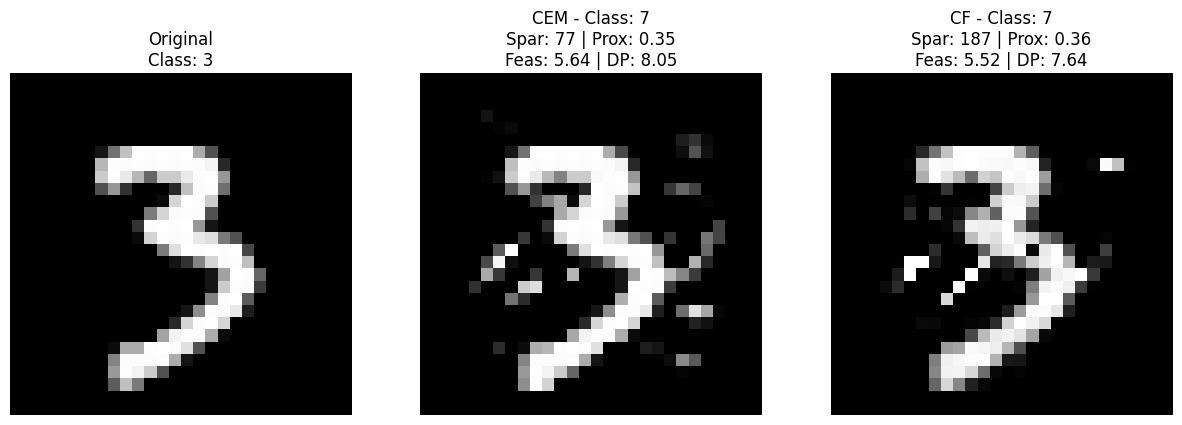


Evaluating original image #5
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 9
Number of instances in the same class (9): 1009
Minimum normalized distance: 0.3918929063349683

Normalized minimum distances for all counterfactuals: [0.3918929063349683]
Calculating proximity...

Counterfactual #1
Original instance #1
Normalized distance between counterfactual and original instance: 0.20820851483269587

Normalized distances for all counterfactuals relative to originals: [0.20820851483269587]
Calculating feasibility...

Counterfactual #1
Feasibility: 4.1366
Calculating discriminative power...

Counterfactual #1
Predicted class for counterfactual: 9
Discriminative power: 5.8155
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 9
Number of instances in the same class (9): 1009
Minimum normalized distance: 0.3568061061623173

Normalized minimum distances for all counterfactuals: [0.3568061061623173]
Calculating proximity.

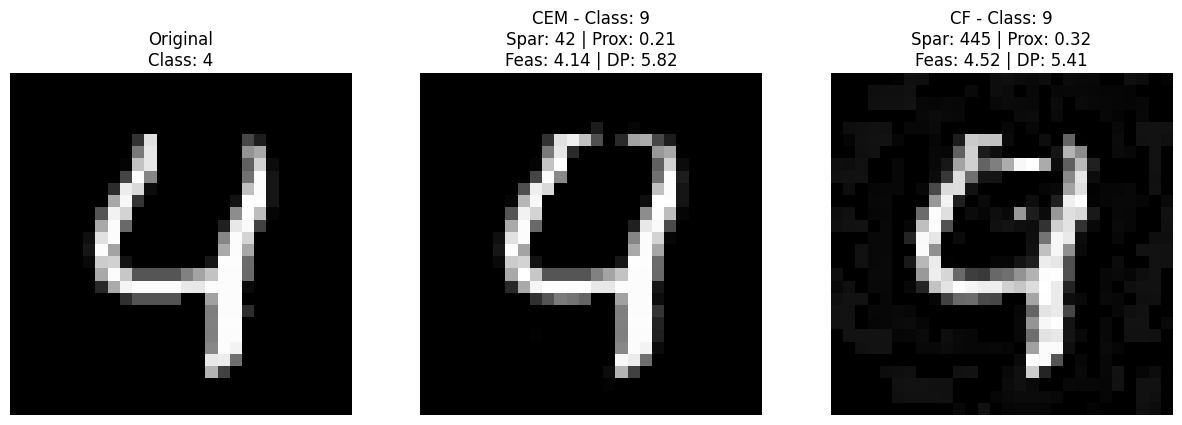


Evaluating original image #6
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 6
Number of instances in the same class (6): 958
Minimum normalized distance: 0.5759121238691246

Normalized minimum distances for all counterfactuals: [0.5759121238691246]
Calculating proximity...

Counterfactual #1
Original instance #1
Normalized distance between counterfactual and original instance: 0.03175248876212128

Normalized distances for all counterfactuals relative to originals: [0.03175248876212128]
Calculating feasibility...

Counterfactual #1
Feasibility: 6.4422
Calculating discriminative power...

Counterfactual #1
Predicted class for counterfactual: 6
Discriminative power: 8.4031
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 6
Number of instances in the same class (6): 958
Minimum normalized distance: 0.5752827521742693

Normalized minimum distances for all counterfactuals: [0.5752827521742693]
Calculating proximity...

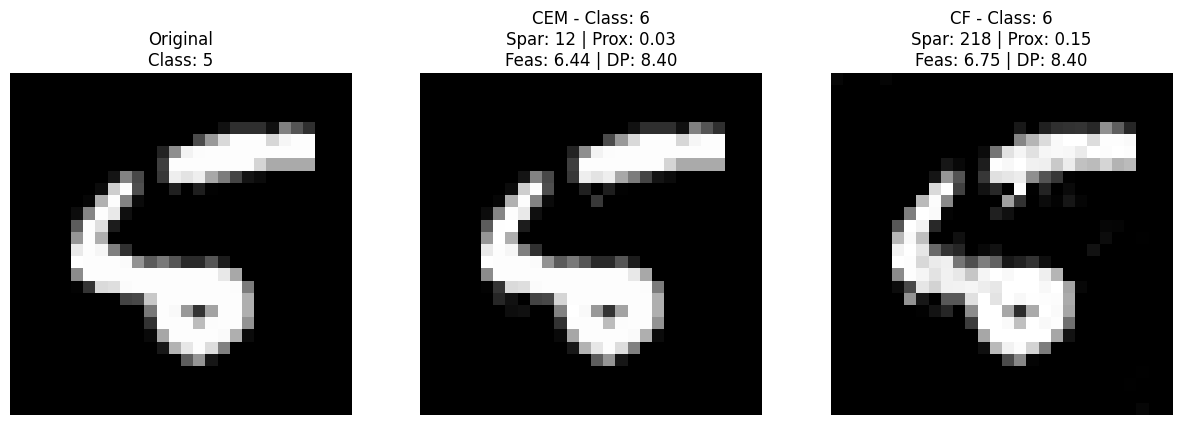


Evaluating original image #7
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 0
Number of instances in the same class (0): 980
Minimum normalized distance: 0.5284248894738132

Normalized minimum distances for all counterfactuals: [0.5284248894738132]
Calculating proximity...

Counterfactual #1
Original instance #1
Normalized distance between counterfactual and original instance: 0.45574558116755476

Normalized distances for all counterfactuals relative to originals: [0.45574558116755476]
Calculating feasibility...

Counterfactual #1
Feasibility: 7.0061
Calculating discriminative power...

Counterfactual #1
Predicted class for counterfactual: 0
Discriminative power: 7.9106
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 0
Number of instances in the same class (0): 980
Minimum normalized distance: 0.481362912483082

Normalized minimum distances for all counterfactuals: [0.481362912483082]
Calculating proximity...



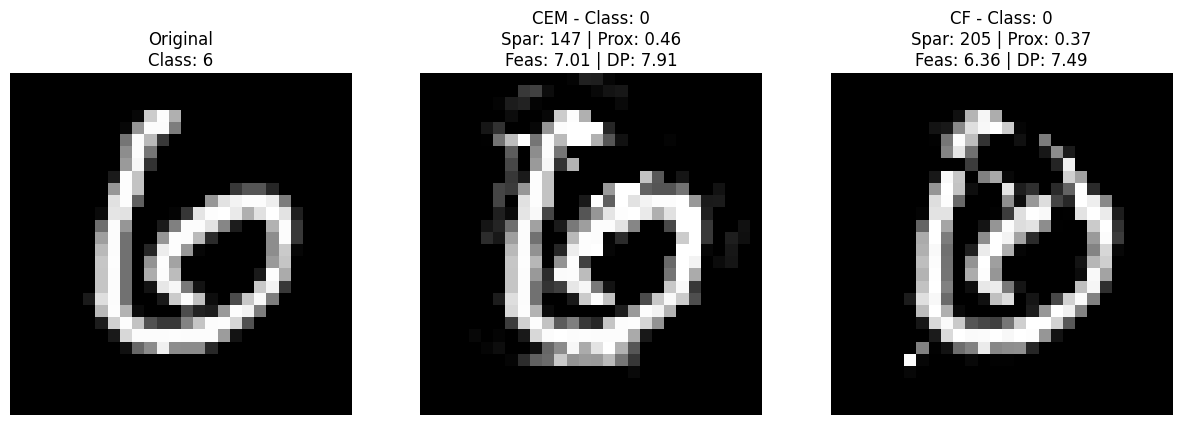


Evaluating original image #8
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 2
Number of instances in the same class (2): 1032
Minimum normalized distance: 0.5268703219160253

Normalized minimum distances for all counterfactuals: [0.5268703219160253]
Calculating proximity...

Counterfactual #1
Original instance #1
Normalized distance between counterfactual and original instance: 0.3930568214377489

Normalized distances for all counterfactuals relative to originals: [0.3930568214377489]
Calculating feasibility...

Counterfactual #1
Feasibility: 4.5968
Calculating discriminative power...

Counterfactual #1
Predicted class for counterfactual: 2
Discriminative power: 8.2807
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 2
Number of instances in the same class (2): 1032
Minimum normalized distance: 0.5313197944194381

Normalized minimum distances for all counterfactuals: [0.5313197944194381]
Calculating proximity...

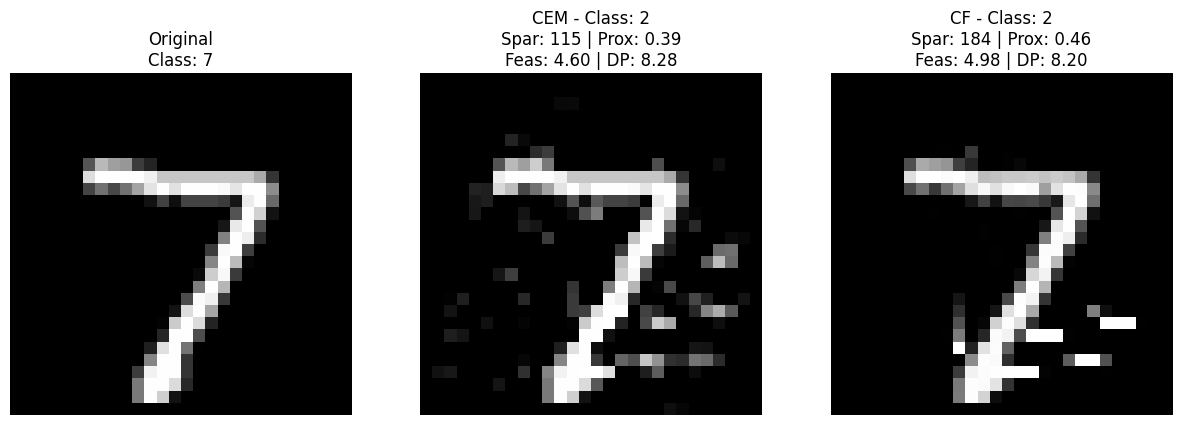


Evaluating original image #9
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 2
Number of instances in the same class (2): 1032
Minimum normalized distance: 0.5006564241540225

Normalized minimum distances for all counterfactuals: [0.5006564241540225]
Calculating proximity...

Counterfactual #1
Original instance #1
Normalized distance between counterfactual and original instance: 0.22358158067017272

Normalized distances for all counterfactuals relative to originals: [0.22358158067017272]
Calculating feasibility...

Counterfactual #1
Feasibility: 6.7123
Calculating discriminative power...

Counterfactual #1
Predicted class for counterfactual: 2
Discriminative power: 7.8751
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 2
Number of instances in the same class (2): 1032
Minimum normalized distance: 0.4561766983421834

Normalized minimum distances for all counterfactuals: [0.4561766983421834]
Calculating proximity.

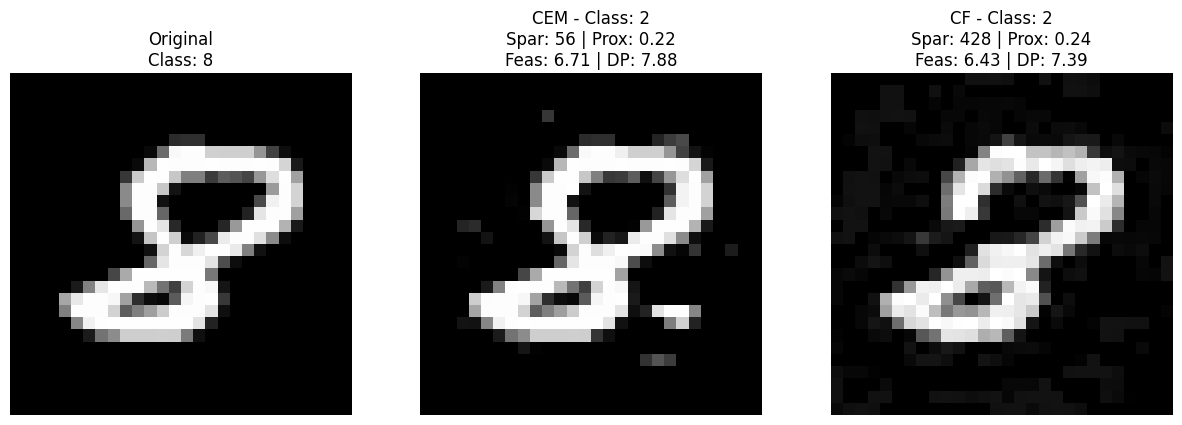


Evaluating original image #10
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 4
Number of instances in the same class (4): 982
Minimum normalized distance: 0.5225446873344103

Normalized minimum distances for all counterfactuals: [0.5225446873344103]
Calculating proximity...

Counterfactual #1
Original instance #1
Normalized distance between counterfactual and original instance: 0.2398951675485936

Normalized distances for all counterfactuals relative to originals: [0.2398951675485936]
Calculating feasibility...

Counterfactual #1
Feasibility: 5.6382
Calculating discriminative power...

Counterfactual #1
Predicted class for counterfactual: 4
Discriminative power: 7.4548
Calculating implausibility...

Counterfactual #1
Predicted class for counterfactual: 4
Number of instances in the same class (4): 982
Minimum normalized distance: 0.5068855166968288

Normalized minimum distances for all counterfactuals: [0.5068855166968288]
Calculating proximity...


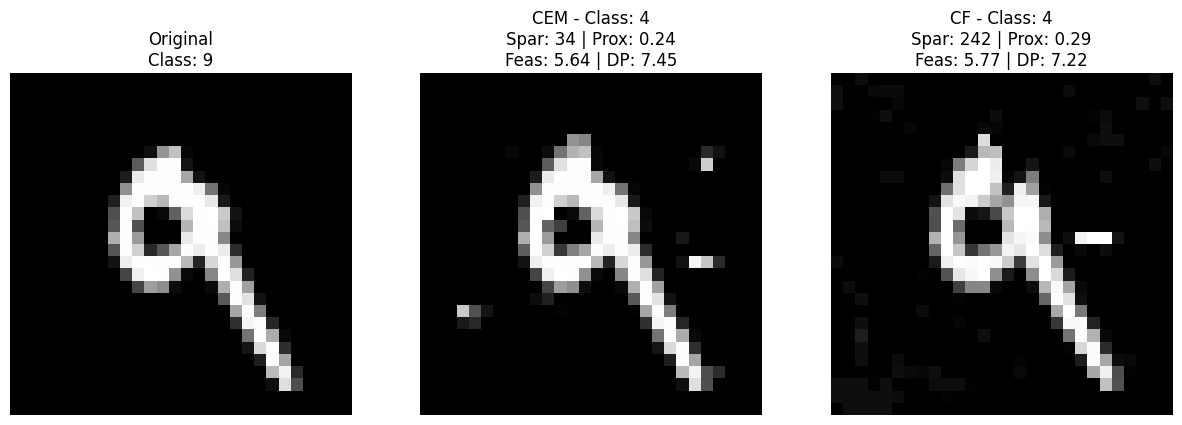

In [42]:
def organize_and_evaluate(originals, cem_counterfactuals, cf_counterfactuals, reference_data, reference_labels, model_predict, k=5, metric='euclidean', input_shape=(28, 28, 1)):
    """
    Organizes, evaluates, and visualizes original images alongside their counterfactuals.
    Returns structured results for building metric rankings.

    Returns:
        - List of results for each original image and its counterfactuals.
    """

    all_results = []

    # Iterate over each original image and its counterfactuals
    for idx, original in enumerate(originals):
        print(f"\nEvaluating original image #{idx + 1}")

        # Get counterfactuals and methods
        counterfactuals = [
            {'method': 'CEM', 'image': cem_counterfactuals[idx]},
            {'method': 'CF', 'image': cf_counterfactuals[idx]}
        ]

        # Prepare the list of metric results
        results = []

        for cf_data in counterfactuals:
            cf_image = cf_data['image']
            method = cf_data['method']

            # Calculate metrics
            impl = calculate_implausibility([cf_image.flatten()], reference_data, reference_labels, model_predict, metric, input_shape)[0]
            prox = calculate_proximity([cf_image.flatten()], [original.flatten()], metric=metric)[0]
            feas = calculate_feasibility([cf_image.flatten()], [original.flatten()], reference_data, k=k, metric=metric)[0]
            dp = calculate_discriminative_power([cf_image.flatten()], reference_data, reference_labels, model_predict, k=k, metric=metric)[0]
            spar = calculate_sparsity(original.flatten(), cf_image.flatten(), threshold=0.0)[0]

            # Save results
            results.append({
                'method': method,
                'cf_image': cf_image,
                'implausibility': impl,
                'proximity': prox,
                'feasibility': feas,
                'discriminative_power': dp,
                'sparsity': spar
            })

        # Visualization
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(1, len(results) + 1, 1)
        plt.imshow(original.reshape(input_shape).squeeze(), cmap='gray')
        original_class = np.argmax(model_predict(original.reshape((1,) + input_shape)), axis=1)[0]
        plt.title(f"Original\nClass: {original_class}")
        plt.axis('off')

        # Visualization of counterfactuals
        for i, result in enumerate(results):
            cf_image = result['cf_image']
            cf_class = np.argmax(model_predict(cf_image.reshape((1,) + input_shape)), axis=1)[0]

            plt.subplot(1, len(results) + 1, i + 2)
            plt.imshow(cf_image.reshape(input_shape).squeeze(), cmap='gray')
            plt.title(f"{result['method']} - Class: {cf_class}\n"
                      f"Spar: {result['sparsity']} | Prox: {result['proximity']:.2f}\n"
                      f"Feas: {result['feasibility']:.2f} | DP: {result['discriminative_power']:.2f}")
            plt.axis('off')

        plt.show()

        # Save all results for this original image
        all_results.append({
            'original_idx': idx,
            'original_image': original,
            'metrics': results
        })

    return all_results


# Execution of the method
originals = [exp['original_image'] for exp in cem_explanations[:10]]  # Original images
cem_counterfactuals = [exp['cf_image'] for exp in cem_explanations[:10]]  # CEM counterfactuals
cf_counterfactuals = [exp['cf_image'] for exp in cf_explanations[:10]]  # CF counterfactuals

all_results = organize_and_evaluate(
    originals, cem_counterfactuals, cf_counterfactuals,
    x_test, y_test, loaded_model.predict, k=5, metric='euclidean'
)

In [43]:
# Display detailed results for rankings
for result in all_results:
    print(f"\nResults for original image #{result['original_idx']}:")
    for metric in result['metrics']:
        print(f"Method: {metric['method']}, Impl: {metric['implausibility']:.4f}, "
              f"Prox: {metric['proximity']:.4f}, Feas: {metric['feasibility']:.4f}, "
              f"DP: {metric['discriminative_power']:.4f}, Spar: {metric['sparsity']}")


Results for original image #0:
Method: CEM, Impl: 0.5213, Prox: 0.3874, Feas: 6.4130, DP: 8.0184, Spar: 171
Method: CF, Impl: 0.4846, Prox: 0.2626, Feas: 5.5584, DP: 7.3386, Spar: 229

Results for original image #1:
Method: CEM, Impl: 0.3861, Prox: 0.3939, Feas: 2.6085, DP: 5.8708, Spar: 23
Method: CF, Impl: 0.4000, Prox: 0.3940, Feas: 2.6638, DP: 5.9077, Spar: 82

Results for original image #2:
Method: CEM, Impl: 0.7156, Prox: 0.2817, Feas: 5.7814, DP: 9.1143, Spar: 132
Method: CF, Impl: 0.6640, Prox: 0.3305, Feas: 5.6563, DP: 8.3305, Spar: 220

Results for original image #3:
Method: CEM, Impl: 0.5728, Prox: 0.3507, Feas: 5.6385, DP: 8.0525, Spar: 77
Method: CF, Impl: 0.5409, Prox: 0.3611, Feas: 5.5203, DP: 7.6438, Spar: 187

Results for original image #4:
Method: CEM, Impl: 0.3919, Prox: 0.2082, Feas: 4.1366, DP: 5.8155, Spar: 42
Method: CF, Impl: 0.3568, Prox: 0.3210, Feas: 4.5218, DP: 5.4097, Spar: 445

Results for original image #5:
Method: CEM, Impl: 0.5759, Prox: 0.0318, Feas: 

In [46]:
# List to store all metric data
data_for_excel = []

# Iterate and extract results
for result in all_results:
    original_idx = result['original_idx']
    for metric in result['metrics']:
        data_for_excel.append({
            'Original Image': original_idx,
            'Method': metric['method'],
            'Implausibility': round(metric['implausibility'], 4),
            'Proximity': round(metric['proximity'], 4),
            'Feasibility': round(metric['feasibility'], 4),
            'Discriminative Power': round(metric['discriminative_power'], 4),
            'Sparsity': metric['sparsity']
        })

# Create a DataFrame
df_metrics = pd.DataFrame(data_for_excel)

# Save the DataFrame to an Excel file
output_file = "Images/Counterfactual/counterfactual_metrics.xlsx"
df_metrics.to_excel(output_file, index=False)

print(f"Results have been saved to {output_file}")

Results have been saved to Images/Counterfactual/counterfactual_metrics.xlsx


##

In [47]:
def generate_rankings_per_image(results):
    """
    Generates individual rankings for each metric and performs the final aggregation using the Borda method
    for each original image.

    Parameters:
        - results: List with the calculated metrics for each original image.

    Returns:
        - rankings_per_image: List with aggregated rankings using the Borda method for each original image.
    """
    metrics = ['implausibility', 'proximity', 'feasibility', 'discriminative_power', 'sparsity']
    rankings_per_image = []  # List to store the final ranking for each original image

    # Iterate over the results for each original image
    for result in results:
        print(f"\nRankings for original image #{result['original_idx'] + 1}:")
        borda_scores = defaultdict(int)  # Reset scores for each image
        rankings = {metric: [] for metric in metrics}

        # Create rankings by metric
        for metric_name in metrics:
            sorted_metrics = sorted(result['metrics'], key=lambda x: x[metric_name])
            print(f"\n{metric_name.capitalize()} Ranking:")

            # Assign Borda points (3, 2, 1...) based on the ranking position
            for rank, metric in enumerate(sorted_metrics, 1):
                print(f"{rank}. Method: {metric['method']}, Value: {metric[metric_name]:.4f}")
                # Add points inversely proportional to the ranking
                borda_scores[metric['method']] += len(sorted_metrics) - rank + 1

        # Generate the final ranking using the accumulated scores
        final_ranking = sorted(borda_scores.items(), key=lambda x: x[1], reverse=True)
        rankings_per_image.append({'original_idx': result['original_idx'], 'final_ranking': final_ranking})

        # Print the final aggregated ranking for this image
        print("\nFinal Aggregated Ranking (Borda Method):")
        for rank, (method, score) in enumerate(final_ranking, 1):
            print(f"{rank}. Method: {method}, Total Score: {score}")

    return rankings_per_image


# Example invocation (using the already calculated structure):
final_rankings = generate_rankings_per_image(all_results)


Rankings for original image #1:

Implausibility Ranking:
1. Method: CF, Value: 0.4846
2. Method: CEM, Value: 0.5213

Proximity Ranking:
1. Method: CF, Value: 0.2626
2. Method: CEM, Value: 0.3874

Feasibility Ranking:
1. Method: CF, Value: 5.5584
2. Method: CEM, Value: 6.4130

Discriminative_power Ranking:
1. Method: CF, Value: 7.3386
2. Method: CEM, Value: 8.0184

Sparsity Ranking:
1. Method: CEM, Value: 171.0000
2. Method: CF, Value: 229.0000

Final Aggregated Ranking (Borda Method):
1. Method: CF, Total Score: 9
2. Method: CEM, Total Score: 6

Rankings for original image #2:

Implausibility Ranking:
1. Method: CEM, Value: 0.3861
2. Method: CF, Value: 0.4000

Proximity Ranking:
1. Method: CEM, Value: 0.3939
2. Method: CF, Value: 0.3940

Feasibility Ranking:
1. Method: CEM, Value: 2.6085
2. Method: CF, Value: 2.6638

Discriminative_power Ranking:
1. Method: CEM, Value: 5.8708
2. Method: CF, Value: 5.9077

Sparsity Ranking:
1. Method: CEM, Value: 23.0000
2. Method: CF, Value: 82.0000



##Ranking Generation

In [48]:
def generate_rankings_table(results, output_excel_path):
    """
    Generates a table with metric values, individual rankings, and the final Borda ranking
    for each original image.

    Parameters:
        - results: List with the calculated metrics for each original image.
        - output_excel_path: Path where the resulting table will be saved in Excel format.

    Returns:
        - df_final: DataFrame with values, rankings, and the final aggregated ranking.
    """
    metrics = ['implausibility', 'proximity', 'feasibility', 'discriminative_power', 'sparsity']
    columns = ['Original Image', 'Metric', 'CEM Value', 'CF Value', 'CEM Ranking', 'CF Ranking', 'Borda Final']
    data = []  # List to store table rows

    # Iterate over each image
    for result in results:
        image_idx = result['original_idx'] + 1
        borda_scores = defaultdict(int)

        # Get metric values and rankings
        for metric_name in metrics:
            sorted_metrics = sorted(result['metrics'], key=lambda x: x[metric_name])
            cem_value = next(m[metric_name] for m in result['metrics'] if m['method'] == 'CEM')
            cf_value = next(m[metric_name] for m in result['metrics'] if m['method'] == 'CF')

            # Assign ranking
            cem_rank = 1 if cem_value <= cf_value else 2
            cf_rank = 1 if cf_value <= cem_value else 2

            # Add Borda points
            borda_scores['CEM'] += len(sorted_metrics) - cem_rank
            borda_scores['CF'] += len(sorted_metrics) - cf_rank

            # Add row for the current metric
            data.append([f"Digit {image_idx}", metric_name.capitalize(), cem_value, cf_value, cem_rank, cf_rank, ""])

        # Final aggregated ranking (Borda method)
        final_ranking = sorted(borda_scores.items(), key=lambda x: x[1], reverse=True)
        borda_winner = f"{final_ranking[0][0]} ({final_ranking[0][1]} points)"
        data.append([f"Digit {image_idx}", "Borda Final", "", "", "", "", borda_winner])

    # Create DataFrame
    df_final = pd.DataFrame(data, columns=columns)

    # Save the DataFrame to Excel
    df_final.to_excel(output_excel_path, index=False)
    print(f"Rankings table saved to: {output_excel_path}")

    return df_final

# Example usage:
output_path = "Images/Counterfactual/rankings_results.xlsx"
rankings_table = generate_rankings_table(all_results, output_path)
print(rankings_table)

Rankings table saved to: Images/Counterfactual/rankings_results.xlsx
   Original Image                Metric CEM Value  CF Value CEM Ranking  \
0         Digit 1        Implausibility  0.521254  0.484645           2   
1         Digit 1             Proximity  0.387417  0.262554           2   
2         Digit 1           Feasibility  6.412958  5.558392           2   
3         Digit 1  Discriminative_power  8.018408  7.338643           2   
4         Digit 1              Sparsity       171       229           1   
5         Digit 1           Borda Final                                   
6         Digit 2        Implausibility   0.38607   0.39997           1   
7         Digit 2             Proximity  0.393905  0.393966           1   
8         Digit 2           Feasibility  2.608525  2.663834           1   
9         Digit 2  Discriminative_power  5.870806  5.907662           1   
10        Digit 2              Sparsity        23        82           1   
11        Digit 2           Bor

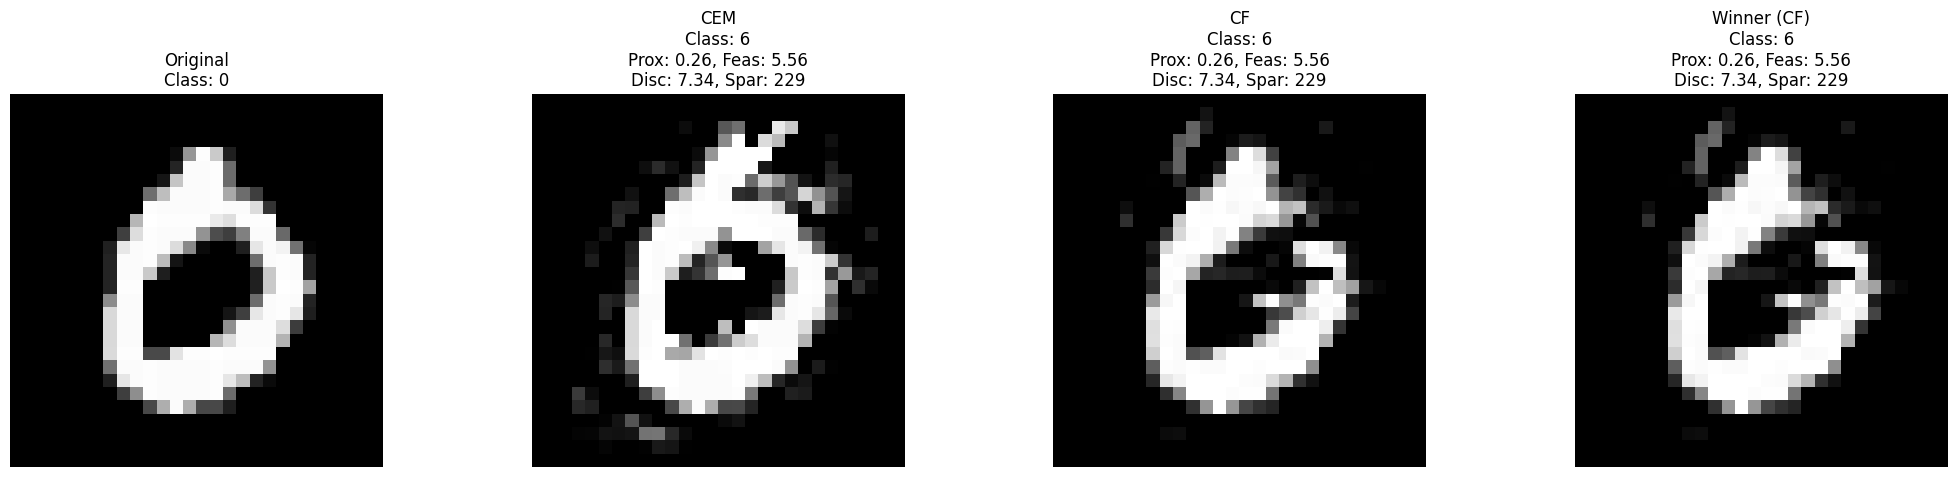

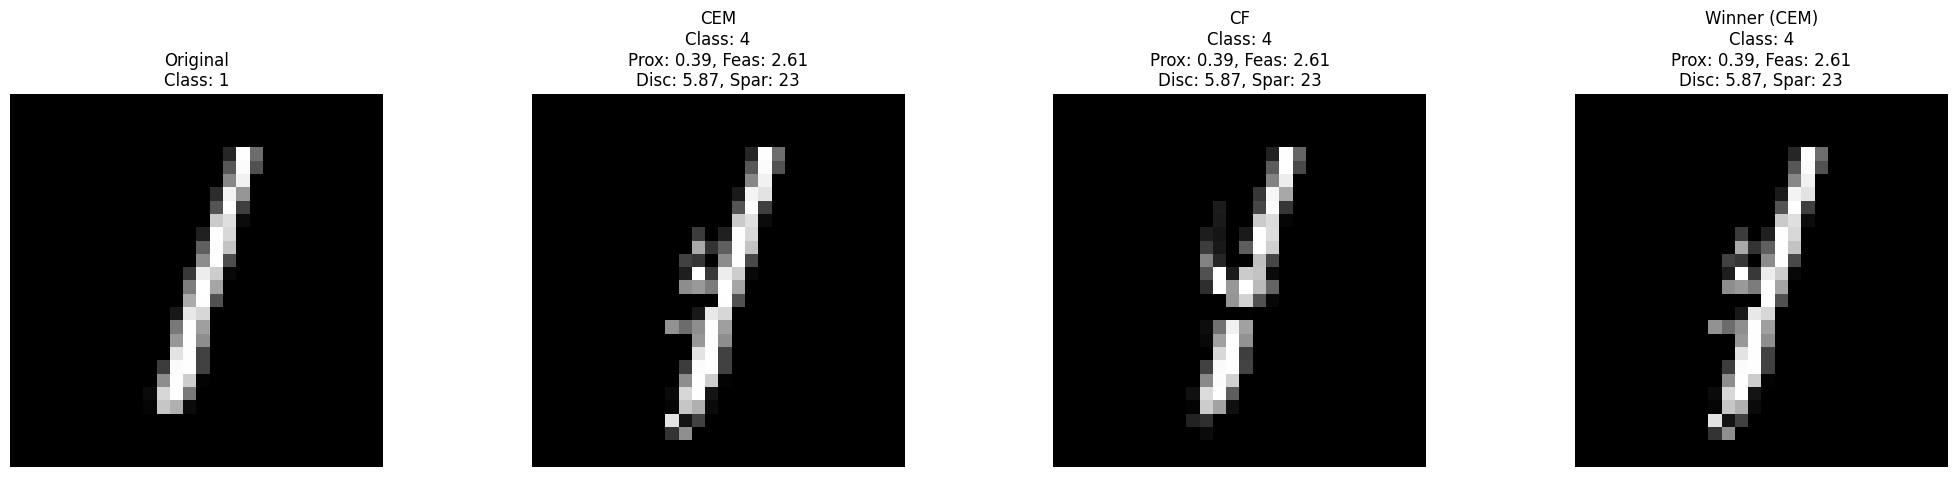

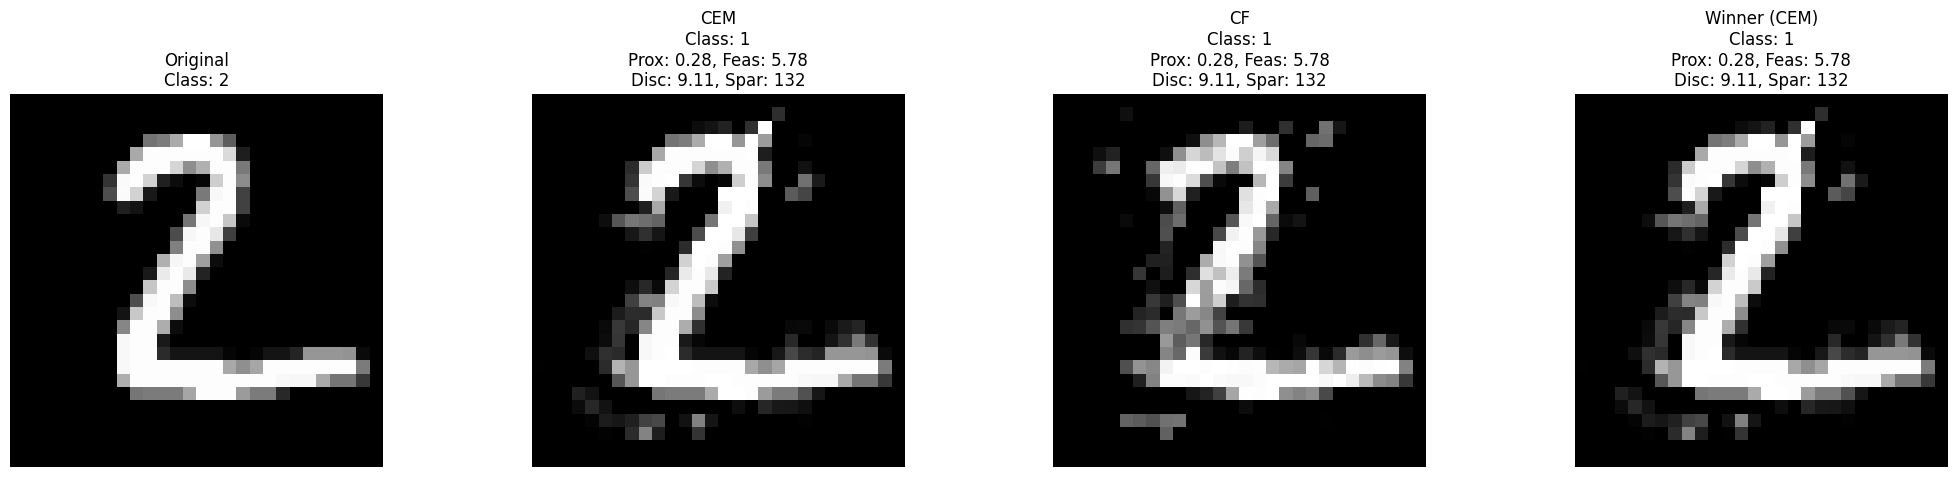

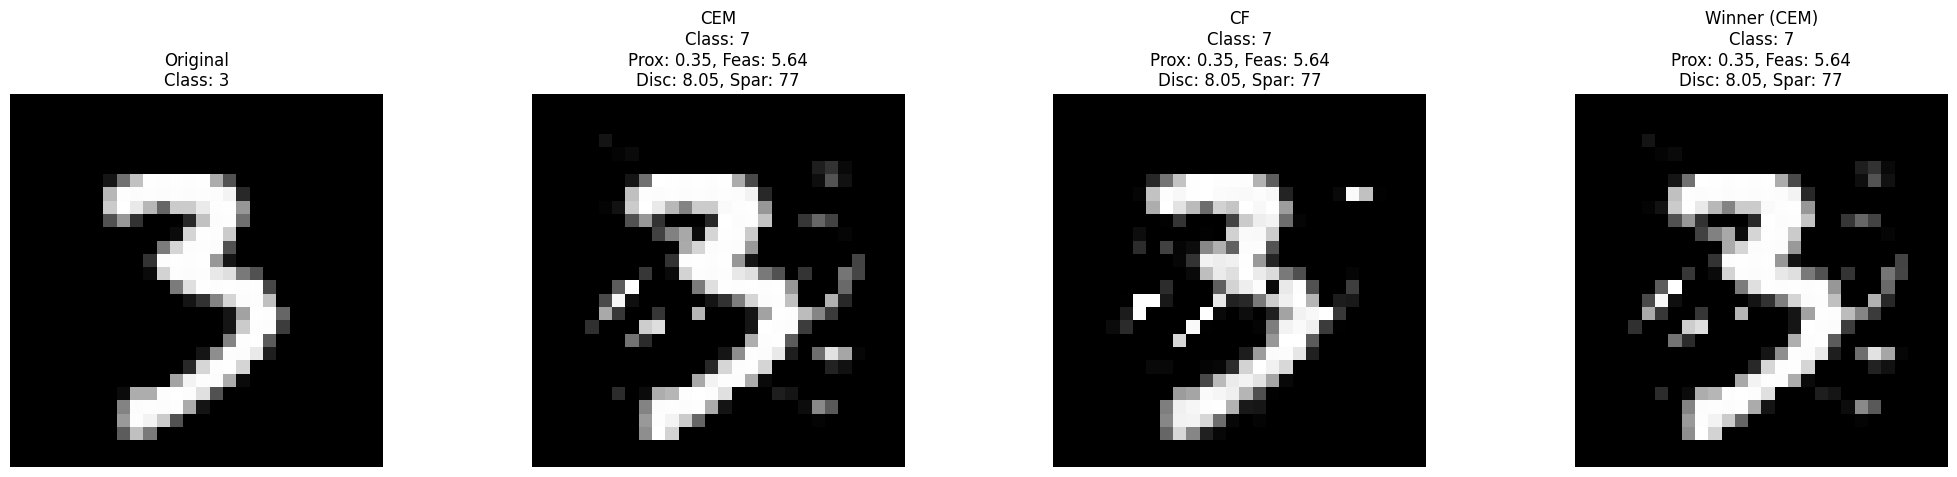

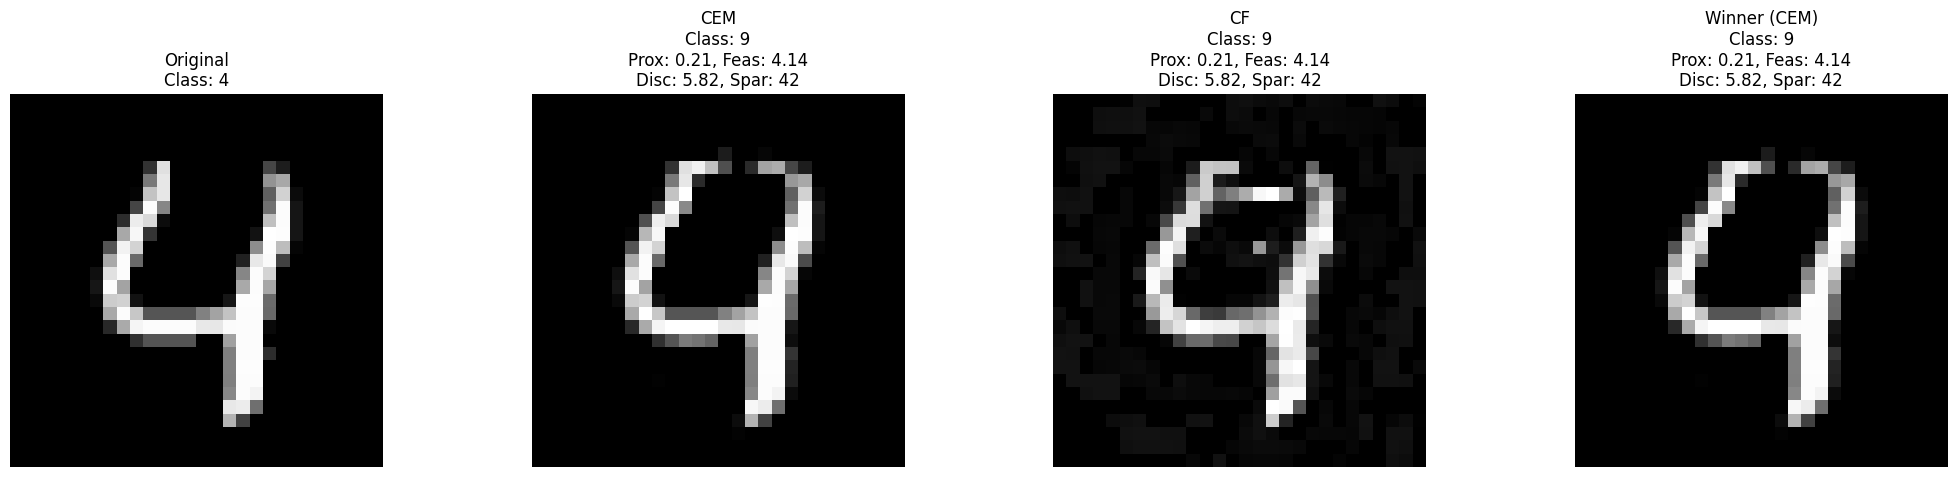

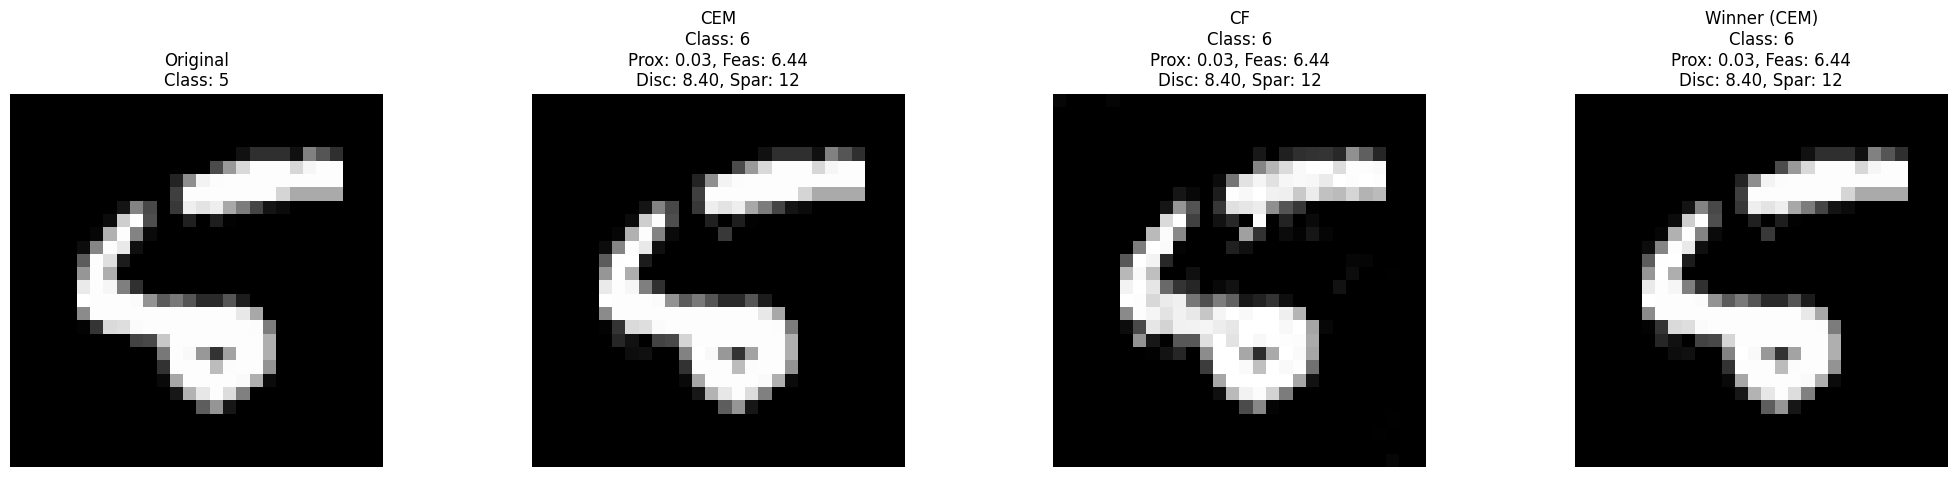

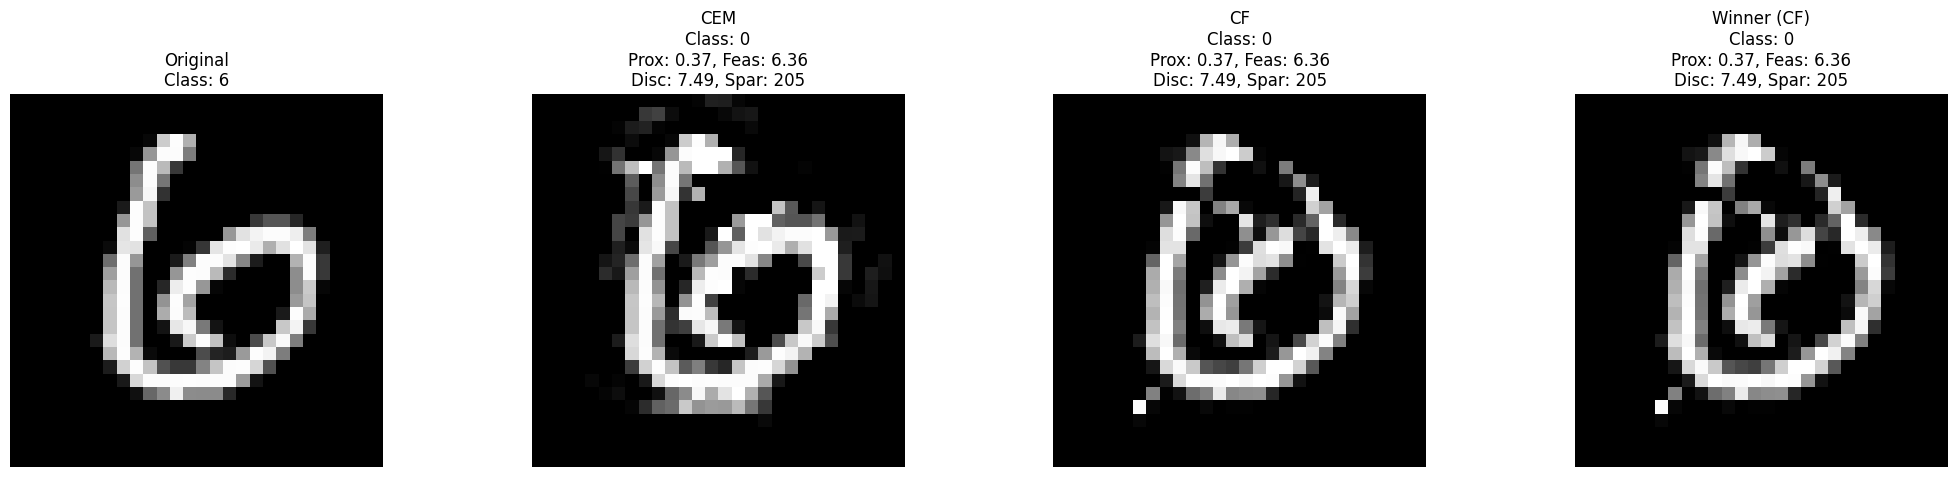

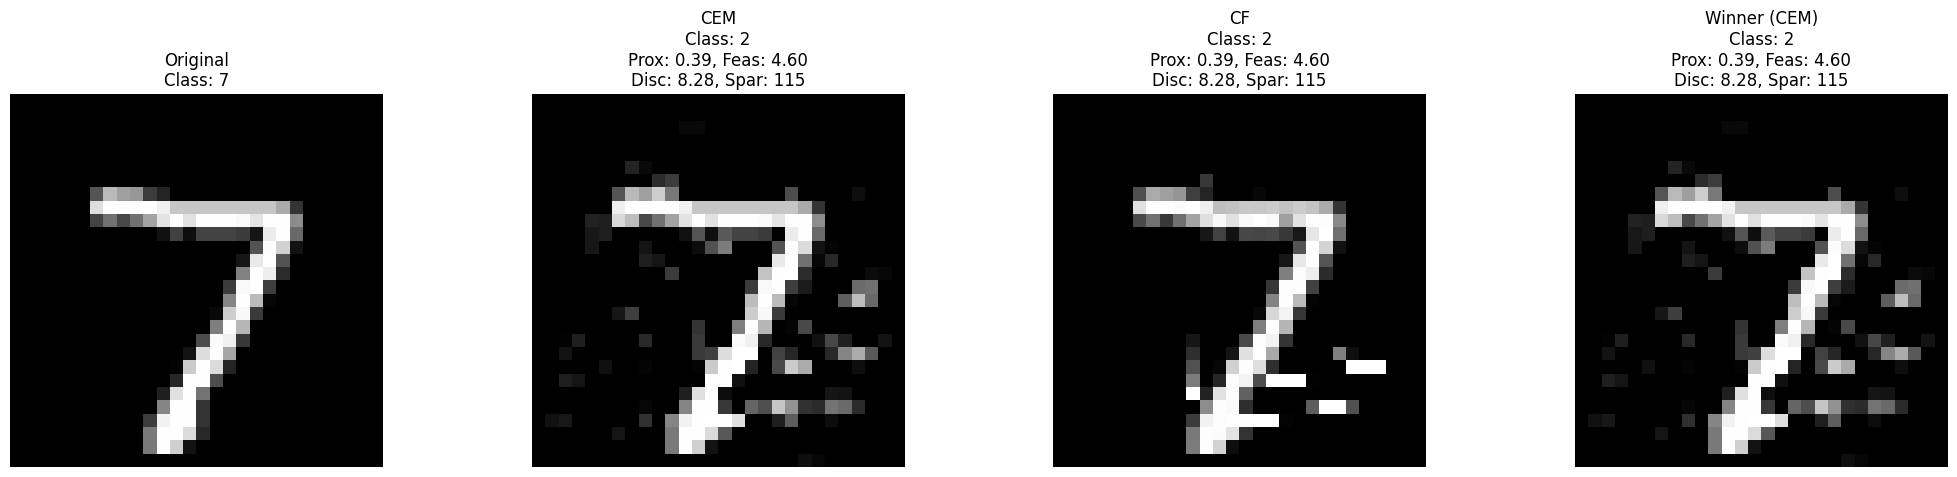

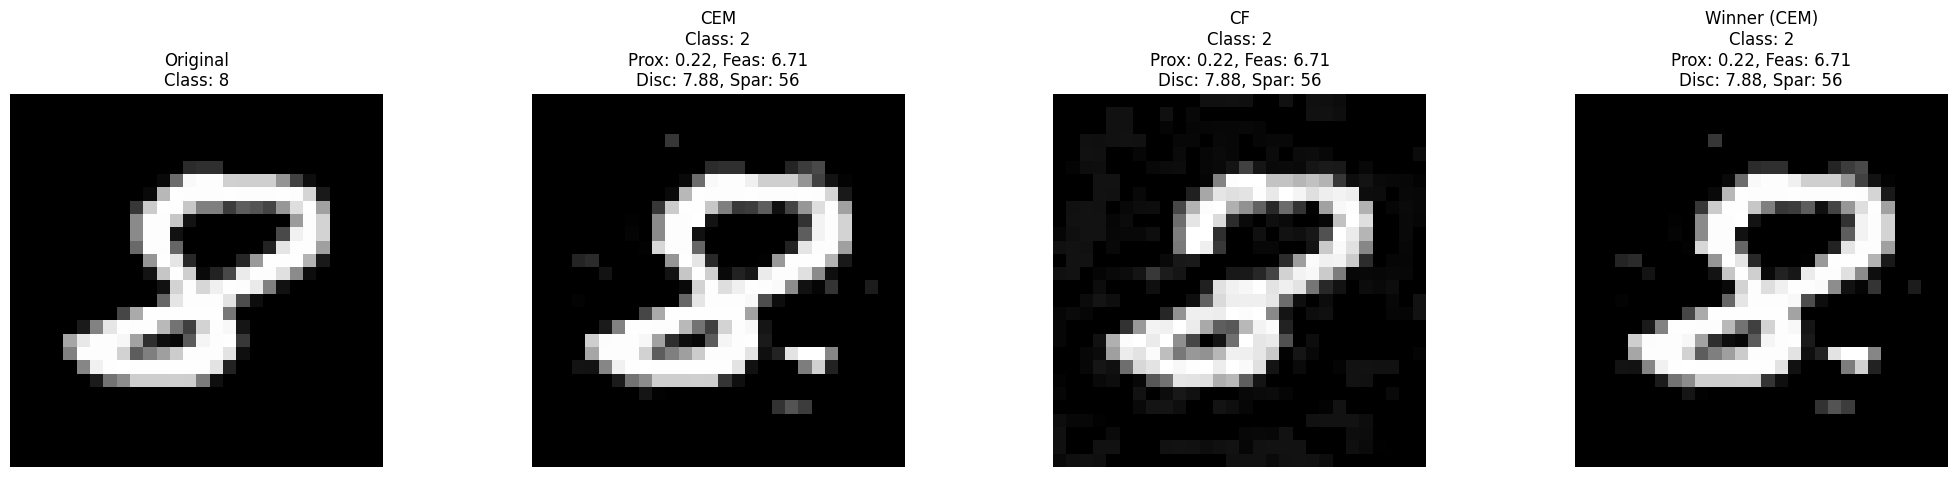

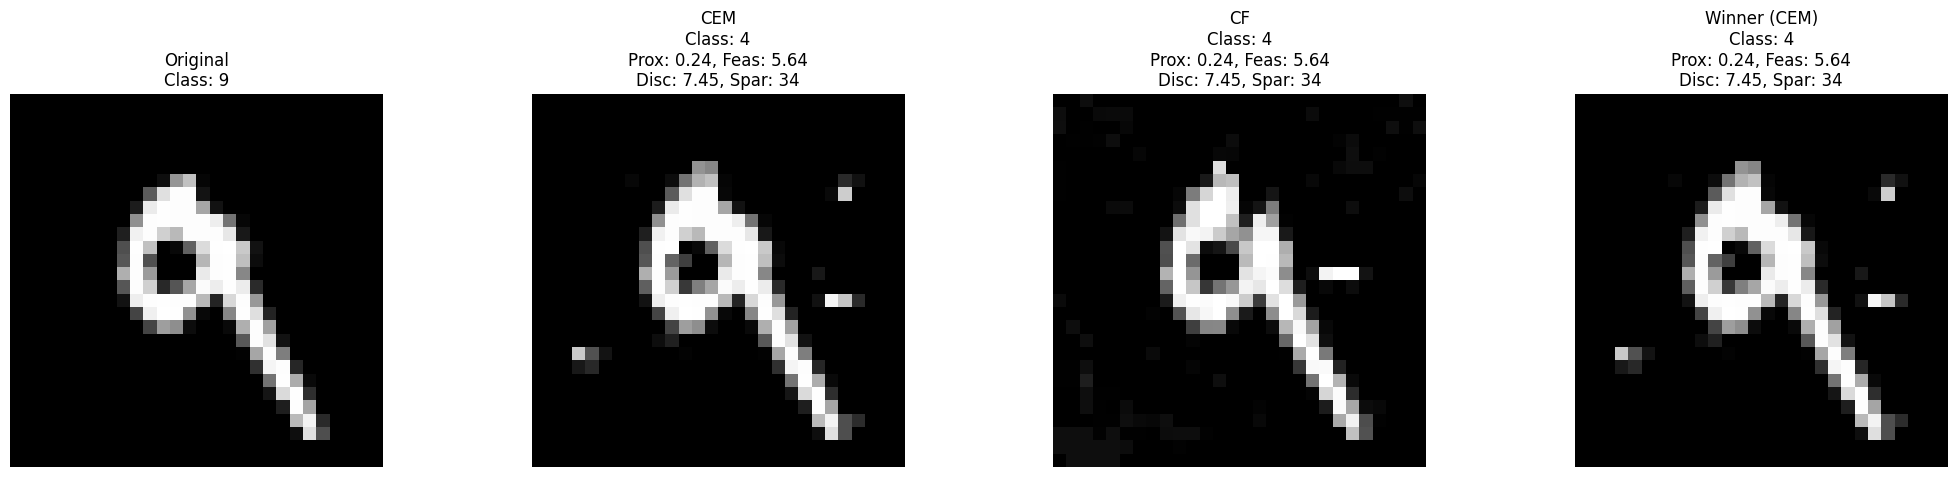

In [49]:
def plot_original_with_all_counterfactuals_and_winner(
    results, original_images, cem_counterfactuals, cf_counterfactuals, model, metrics=None, save_path=None
):
    """
    Visualizes the original image alongside the counterfactuals from each method and the ranking winner.

    Args:
        results: List with calculated metrics for each original image.
        original_images: List or array with original images.
        cem_counterfactuals: List or array with counterfactuals generated by CEM.
        cf_counterfactuals: List or array with counterfactuals generated by CF.
        model: Model for making predictions.
        metrics: List of metrics to consider for ranking (default: ['proximity', 'feasibility', 'discriminative_power', 'sparsity']).
        save_path: Path to save the visualizations (optional).

    Returns:
        ranked_counterfactuals: List of the selected counterfactuals based on the ranking.
    """
    if metrics is None:
        metrics = ['proximity', 'feasibility', 'discriminative_power', 'sparsity']

    ranked_counterfactuals = []  # List to store the winning counterfactuals

    for result in results:
        image_idx = result['original_idx']
        borda_scores = defaultdict(int)

        # Calculate Borda scores
        for metric_name in metrics:
            sorted_metrics = sorted(result['metrics'], key=lambda x: x[metric_name])
            for rank, metric in enumerate(sorted_metrics, 1):
                borda_scores[metric['method']] += len(sorted_metrics) - rank

        # Determine the winning method
        best_method = max(borda_scores.items(), key=lambda x: x[1])[0]
        best_cf = cem_counterfactuals[image_idx] if best_method == 'CEM' else cf_counterfactuals[image_idx]

        # Add the winning counterfactual to the list
        ranked_counterfactuals.append(best_cf)

        # Get metrics of the winning counterfactual
        method_metrics = next(item for item in result['metrics'] if item['method'] == best_method)

        # Predictions
        original_pred = np.argmax(model.predict(np.expand_dims(original_images[image_idx], axis=0)), axis=1)[0]
        cem_pred = np.argmax(model.predict(cem_counterfactuals[image_idx]), axis=1)[0]
        cf_pred = np.argmax(model.predict(cf_counterfactuals[image_idx]), axis=1)[0]
        best_pred = np.argmax(model.predict(best_cf), axis=1)[0]

        # Visualization
        fig, axes = plt.subplots(1, 4, figsize=(25, 5))

        # Original image
        axes[0].imshow(original_images[image_idx].squeeze(), cmap='gray')
        axes[0].set_title(f"Original\nClass: {original_pred}")
        axes[0].axis('off')

        # CEM counterfactual
        axes[1].imshow(cem_counterfactuals[image_idx].squeeze(), cmap='gray')
        axes[1].set_title(
            f"CEM\nClass: {cem_pred}\nProx: {method_metrics['proximity']:.2f}, Feas: {method_metrics['feasibility']:.2f}\nDisc: {method_metrics['discriminative_power']:.2f}, Spar: {method_metrics['sparsity']}"
        )
        axes[1].axis('off')

        # CF counterfactual
        axes[2].imshow(cf_counterfactuals[image_idx].squeeze(), cmap='gray')
        axes[2].set_title(
            f"CF\nClass: {cf_pred}\nProx: {method_metrics['proximity']:.2f}, Feas: {method_metrics['feasibility']:.2f}\nDisc: {method_metrics['discriminative_power']:.2f}, Spar: {method_metrics['sparsity']}"
        )
        axes[2].axis('off')

        # Winning counterfactual
        axes[3].imshow(best_cf.squeeze(), cmap='gray')
        axes[3].set_title(
            f"Winner ({best_method})\nClass: {best_pred}\nProx: {method_metrics['proximity']:.2f}, Feas: {method_metrics['feasibility']:.2f}\nDisc: {method_metrics['discriminative_power']:.2f}, Spar: {method_metrics['sparsity']}"
        )
        axes[3].axis('off')

        # Adjust horizontal spacing
        plt.subplots_adjust(wspace=0.4)

        # Save visualization if a path is provided
        if save_path:
            plt.savefig(f"{save_path}/original_{image_idx + 1}_all_cfs_with_winner.png")

        plt.show()

    return np.array(ranked_counterfactuals)

# Function call
ranked_counterfactuals = plot_original_with_all_counterfactuals_and_winner(
    results=all_results,
    original_images=x_selected,
    cem_counterfactuals=cem_counterfactuals,
    cf_counterfactuals=cf_counterfactuals,
    model=loaded_model,
    metrics=['proximity', 'feasibility', 'discriminative_power', 'sparsity'],
    save_path=None
)

(1, 28, 28, 1)


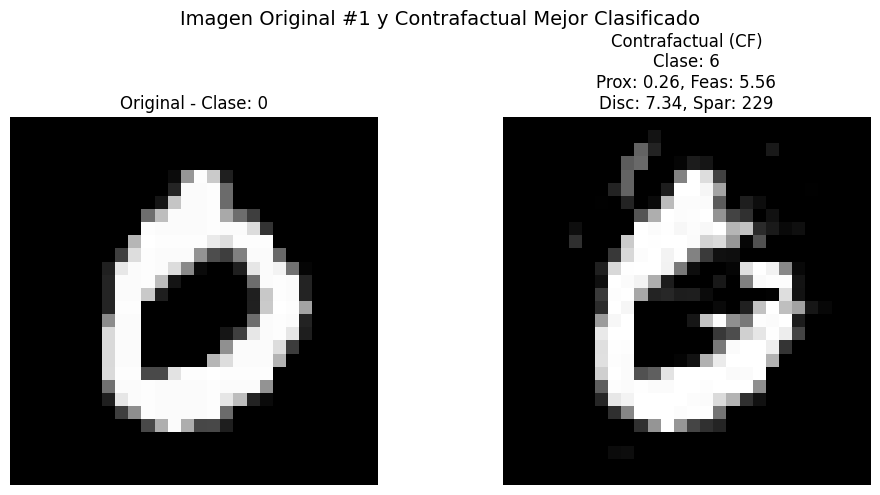

(1, 28, 28, 1)


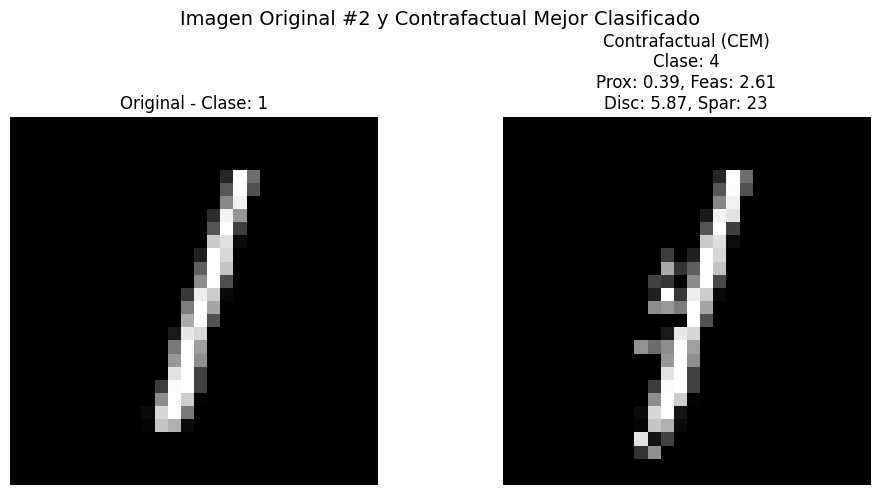

(1, 28, 28, 1)


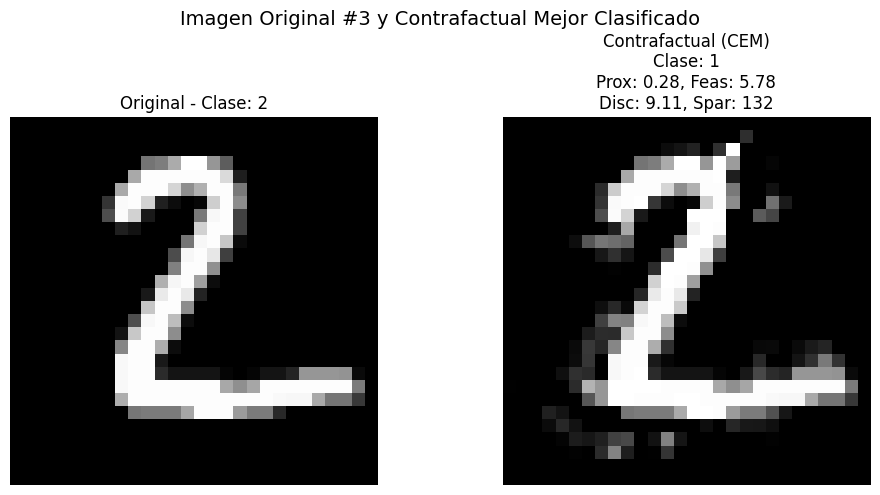

(1, 28, 28, 1)


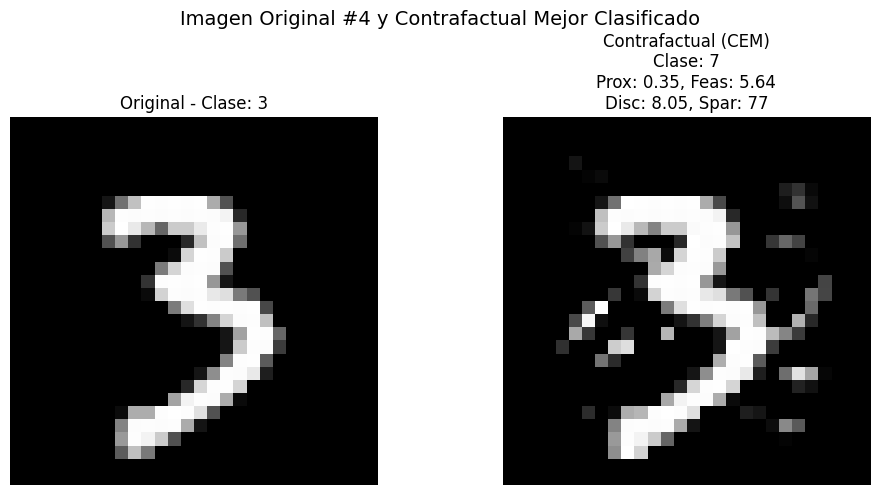

(1, 28, 28, 1)


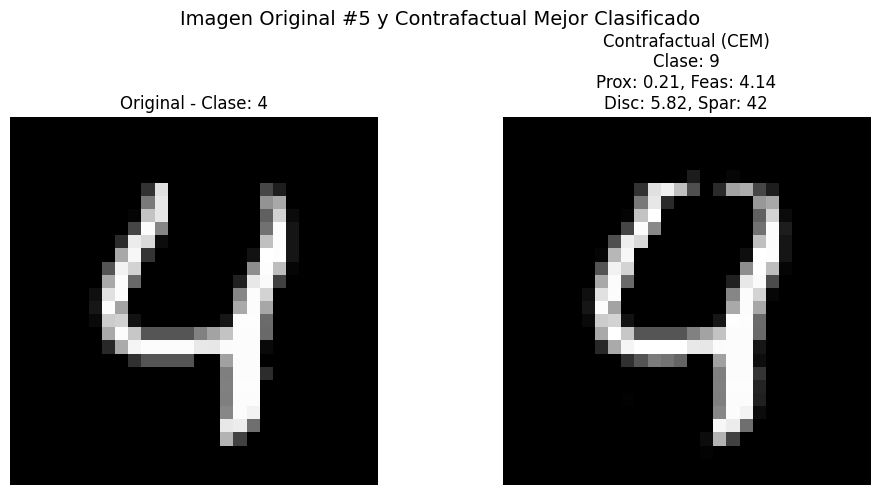

(1, 28, 28, 1)


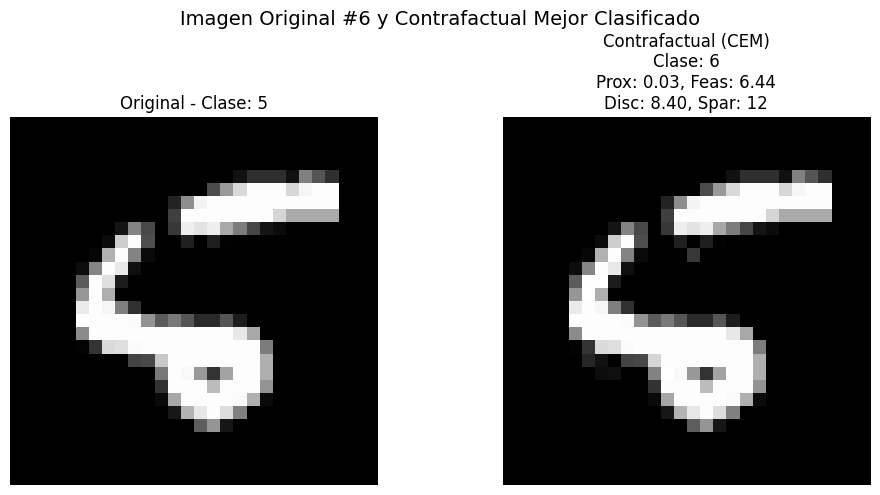

(1, 28, 28, 1)


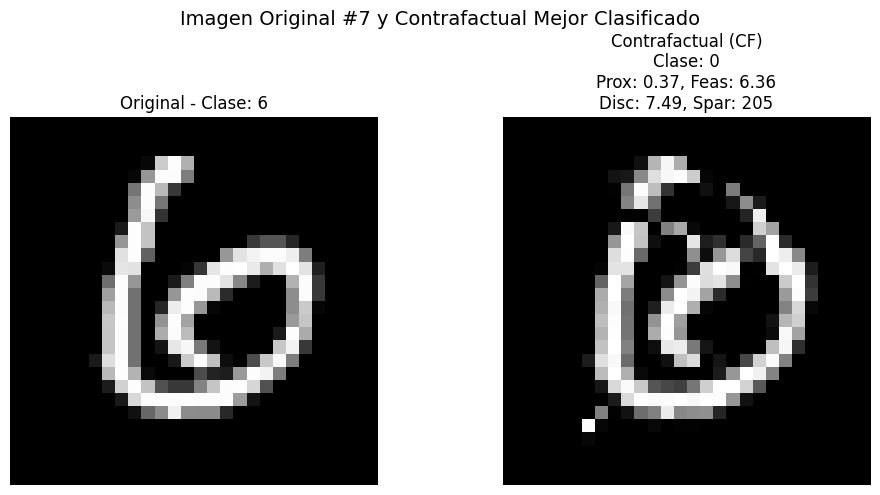

(1, 28, 28, 1)


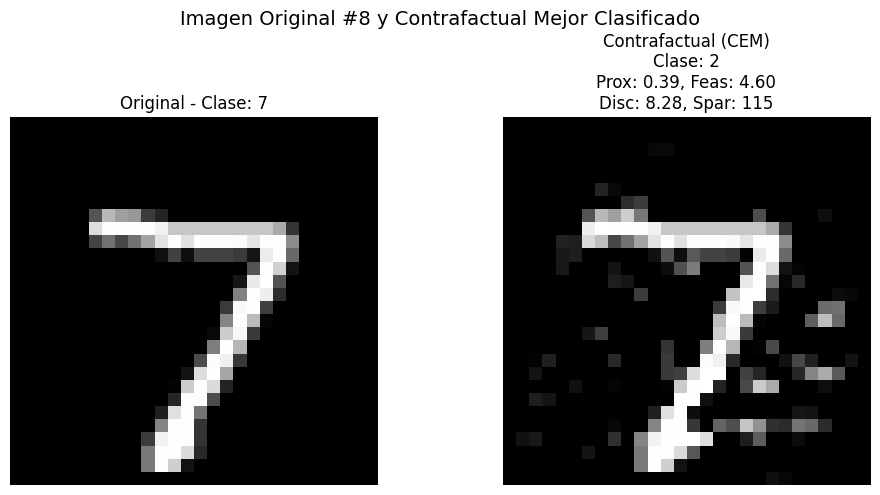

(1, 28, 28, 1)


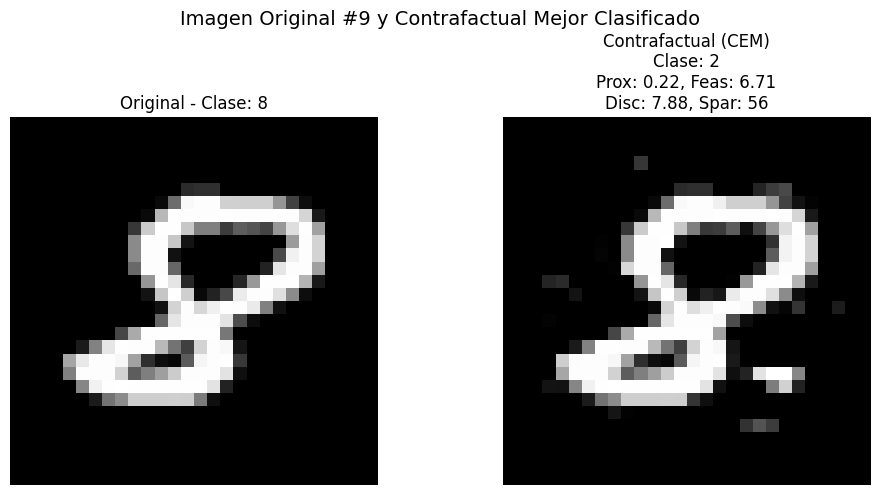

(1, 28, 28, 1)


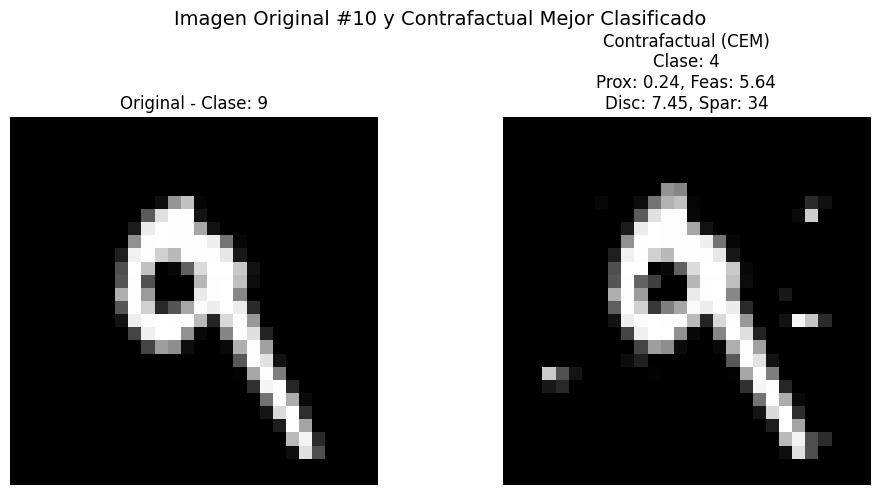

In [50]:
def plot_original_with_best_ranked_counterfactual(results, original_images, cem_counterfactuals, cf_counterfactuals, model):
    """
    Plotea la imagen original junto con el contrafactual en el primer lugar del ranking de Borda.
    El título del contrafactual incluye la clase predicha y las métricas evaluadas.

    Parámetros:
        - results: Lista con las métricas calculadas para cada imagen original.
        - original_images: Lista o array con las imágenes originales.
        - cem_counterfactuals: Lista o array con contrafactuales generados por el método CEM.
        - cf_counterfactuals: Lista o array con contrafactuales generados por el método CF.
        - model: Modelo CNN utilizado para hacer las predicciones.
    """
    metrics = ['proximity', 'feasibility', 'discriminative_power', 'sparsity']

    for result in results:
        image_idx = result['original_idx']
        borda_scores = defaultdict(int)

        # Calcular puntajes de Borda
        for metric_name in metrics:
            sorted_metrics = sorted(result['metrics'], key=lambda x: x[metric_name])
            for rank, metric in enumerate(sorted_metrics, 1):
                borda_scores[metric['method']] += len(sorted_metrics) - rank

        # Determinar el método ganador
        best_method = max(borda_scores.items(), key=lambda x: x[1])[0]
        if best_method == 'CEM':
            counterfactual = cem_counterfactuals[image_idx]
        else:
            counterfactual = cf_counterfactuals[image_idx]

        # Obtener las métricas del contrafactual ganador
        method_metrics = next(item for item in result['metrics'] if item['method'] == best_method)

        # Predecir la clase original y contrafactual
        original_pred = np.argmax(model.predict(np.expand_dims(original_images[image_idx], axis=0)), axis=1)[0]
        print(counterfactual.shape)
        counterfactual_pred = np.argmax(model.predict(counterfactual), axis=1)[0]

        # Visualización
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Imagen original
        axes[0].imshow(original_images[image_idx].squeeze(), cmap='gray')
        axes[0].set_title(f"Original - Clase: {original_pred}")
        axes[0].axis('off')

        # Imagen contrafactual
        axes[1].imshow(counterfactual.squeeze(), cmap='gray')
        axes[1].set_title(
            f"Contrafactual ({best_method})\n"
            f"Clase: {counterfactual_pred}\n"
            f"Prox: {method_metrics['proximity']:.2f}, Feas: {method_metrics['feasibility']:.2f}\n"
            f"Disc: {method_metrics['discriminative_power']:.2f}, Spar: {method_metrics['sparsity']}"
        )
        axes[1].axis('off')

        plt.suptitle(f"Imagen Original #{image_idx + 1} y Contrafactual Mejor Clasificado", fontsize=14)
        plt.tight_layout()
        plt.show()

# Llamada a la función
plot_original_with_best_ranked_counterfactual(
    results=all_results,
    original_images=x_selected,
    cem_counterfactuals=cem_counterfactuals,
    cf_counterfactuals=cf_counterfactuals,
    model=loaded_model
)


In [51]:
# Print the summary of the final rankings for each original image
print("\nSummary of Final Rankings by Image:")
for ranking in final_rankings:
    print(f"Image #{ranking['original_idx'] + 1}:")
    for rank, (method, score) in enumerate(ranking['final_ranking'], 1):
        print(f"  {rank}. Method: {method}, Total Score: {score}")


Summary of Final Rankings by Image:
Image #1:
  1. Method: CF, Total Score: 9
  2. Method: CEM, Total Score: 6
Image #2:
  1. Method: CEM, Total Score: 10
  2. Method: CF, Total Score: 5
Image #3:
  1. Method: CF, Total Score: 8
  2. Method: CEM, Total Score: 7
Image #4:
  1. Method: CF, Total Score: 8
  2. Method: CEM, Total Score: 7
Image #5:
  1. Method: CEM, Total Score: 8
  2. Method: CF, Total Score: 7
Image #6:
  1. Method: CEM, Total Score: 8
  2. Method: CF, Total Score: 7
Image #7:
  1. Method: CF, Total Score: 9
  2. Method: CEM, Total Score: 6
Image #8:
  1. Method: CEM, Total Score: 9
  2. Method: CF, Total Score: 6
Image #9:
  1. Method: CF, Total Score: 8
  2. Method: CEM, Total Score: 7
Image #10:
  1. Method: CEM, Total Score: 8
  2. Method: CF, Total Score: 7


In [52]:
ranked_counterfactuals = ranked_counterfactuals.reshape(-1, 28, 28, 1)
print("New shape of ranked_counterfactuals:", ranked_counterfactuals.shape)

New shape of ranked_counterfactuals: (10, 28, 28, 1)


In [53]:
def reshape_counterfactuals(counterfactuals):
    """
    Adjusts the dimensions of the counterfactuals if they have excess dimensions.

    Args:
        counterfactuals: Array or list containing counterfactuals.

    Returns:
        Array with corrected shape.
    """
    counterfactuals = np.array(counterfactuals)
    if counterfactuals.shape[1] == 1:  # If there is an unnecessary extra dimension
        counterfactuals = counterfactuals[:, 0]  # Remove the second dimension
    return counterfactuals

In [54]:
def plot_combined_explanations(
    original_images, cem_counterfactuals, cf_counterfactuals, ranked_counterfactuals, model, save_path=None
):
    """
    Generates a grid with 10 columns (digits) and 4 rows (methods: Original, CEM, CF, Winner).

    Args:
        original_images: List or array of original images.
        cem_counterfactuals: List or array of counterfactuals generated by CEM.
        cf_counterfactuals: List or array of counterfactuals generated by CF.
        ranked_counterfactuals: List or array of counterfactuals selected by ranking.
        model: CNN model used for predictions.
        save_path: Path to save the visualization (optional).
    """
    # Adjust counterfactual dimensions
    cem_counterfactuals = reshape_counterfactuals(cem_counterfactuals)
    cf_counterfactuals = reshape_counterfactuals(cf_counterfactuals)

    num_images = len(original_images)  # Total columns
    rows = 4  # Rows for Original, CEM, CF, and Winner

    print(f"Number of images (columns): {num_images}")
    print(f"Original images shape: {np.array(original_images).shape}")
    print(f"Adjusted CEM counterfactuals shape: {cem_counterfactuals.shape}")
    print(f"Adjusted CF counterfactuals shape: {cf_counterfactuals.shape}")
    print(f"Ranked counterfactuals shape: {np.array(ranked_counterfactuals).shape}")

    # Create figure
    fig, axs = plt.subplots(rows, num_images, figsize=(num_images * 3, 12))
    axs = np.atleast_2d(axs)  # Ensure axs is a 2D array
    fig.suptitle("Counterfactual Visualization", fontsize=20, fontweight="bold")

    print(f"axs dimensions: {axs.shape}")  # Verify axs dimensions

    # Class predictions for each set
    original_preds = np.argmax(model.predict(original_images), axis=1)
    print(f"Original image predictions: {original_preds}")

    cem_preds = np.argmax(model.predict(cem_counterfactuals), axis=1)
    print(f"CEM counterfactual predictions: {cem_preds}")

    cf_preds = np.argmax(model.predict(cf_counterfactuals), axis=1)
    print(f"CF counterfactual predictions: {cf_preds}")

    ranked_preds = np.argmax(model.predict(ranked_counterfactuals), axis=1)
    print(f"Winner counterfactual predictions: {ranked_preds}")

    # Row labels
    row_labels = ["Original", "CEM", "CF", "Borda Winner"]

    for i in range(num_images):
        print(f"\nProcessing image {i + 1}/{num_images}")

        # Row 1: Original image
        axs[0, i].imshow(original_images[i].squeeze(), cmap="gray")
        axs[0, i].set_title(f"Class: {original_preds[i]}", fontsize=14)
        axs[0, i].axis("off")

        # Row 2: CEM counterfactual
        axs[1, i].imshow(cem_counterfactuals[i].squeeze(), cmap="gray")
        axs[1, i].set_title(f"Class: {cem_preds[i]}", fontsize=14)
        axs[1, i].axis("off")

        # Row 3: CF counterfactual
        axs[2, i].imshow(cf_counterfactuals[i].squeeze(), cmap="gray")
        axs[2, i].axis("off")

        # Row 4: Winner counterfactual
        axs[3, i].imshow(ranked_counterfactuals[i].squeeze(), cmap="gray")
        axs[3, i].axis("off")

    # Add labels to the left of each row
    for row, label in enumerate(row_labels):
        axs[row, 0].text(
            -0.5, 0.5, label, fontsize=16, fontweight="bold", ha="right", va="center", transform=axs[row, 0].transAxes
        )

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # Save the visualization if a path is provided
    if save_path:
        print(f"Saving the figure at {save_path}")
        plt.savefig(save_path, bbox_inches="tight")

    print("Displaying the figure")
    plt.show()

Number of images (columns): 10
Original images shape: (10, 28, 28, 1)
Adjusted CEM counterfactuals shape: (10, 28, 28, 1)
Adjusted CF counterfactuals shape: (10, 28, 28, 1)
Ranked counterfactuals shape: (10, 28, 28, 1)
axs dimensions: (4, 10)
Original image predictions: [0 1 2 3 4 5 6 7 8 9]
CEM counterfactual predictions: [6 4 1 7 9 6 0 2 2 4]
CF counterfactual predictions: [6 4 1 7 9 6 0 2 2 4]
Winner counterfactual predictions: [6 4 1 7 9 6 0 2 2 4]

Processing image 1/10

Processing image 2/10

Processing image 3/10

Processing image 4/10

Processing image 5/10

Processing image 6/10

Processing image 7/10

Processing image 8/10

Processing image 9/10

Processing image 10/10
Saving the figure at Images/Counterfactual/combined_explanations.png
Displaying the figure


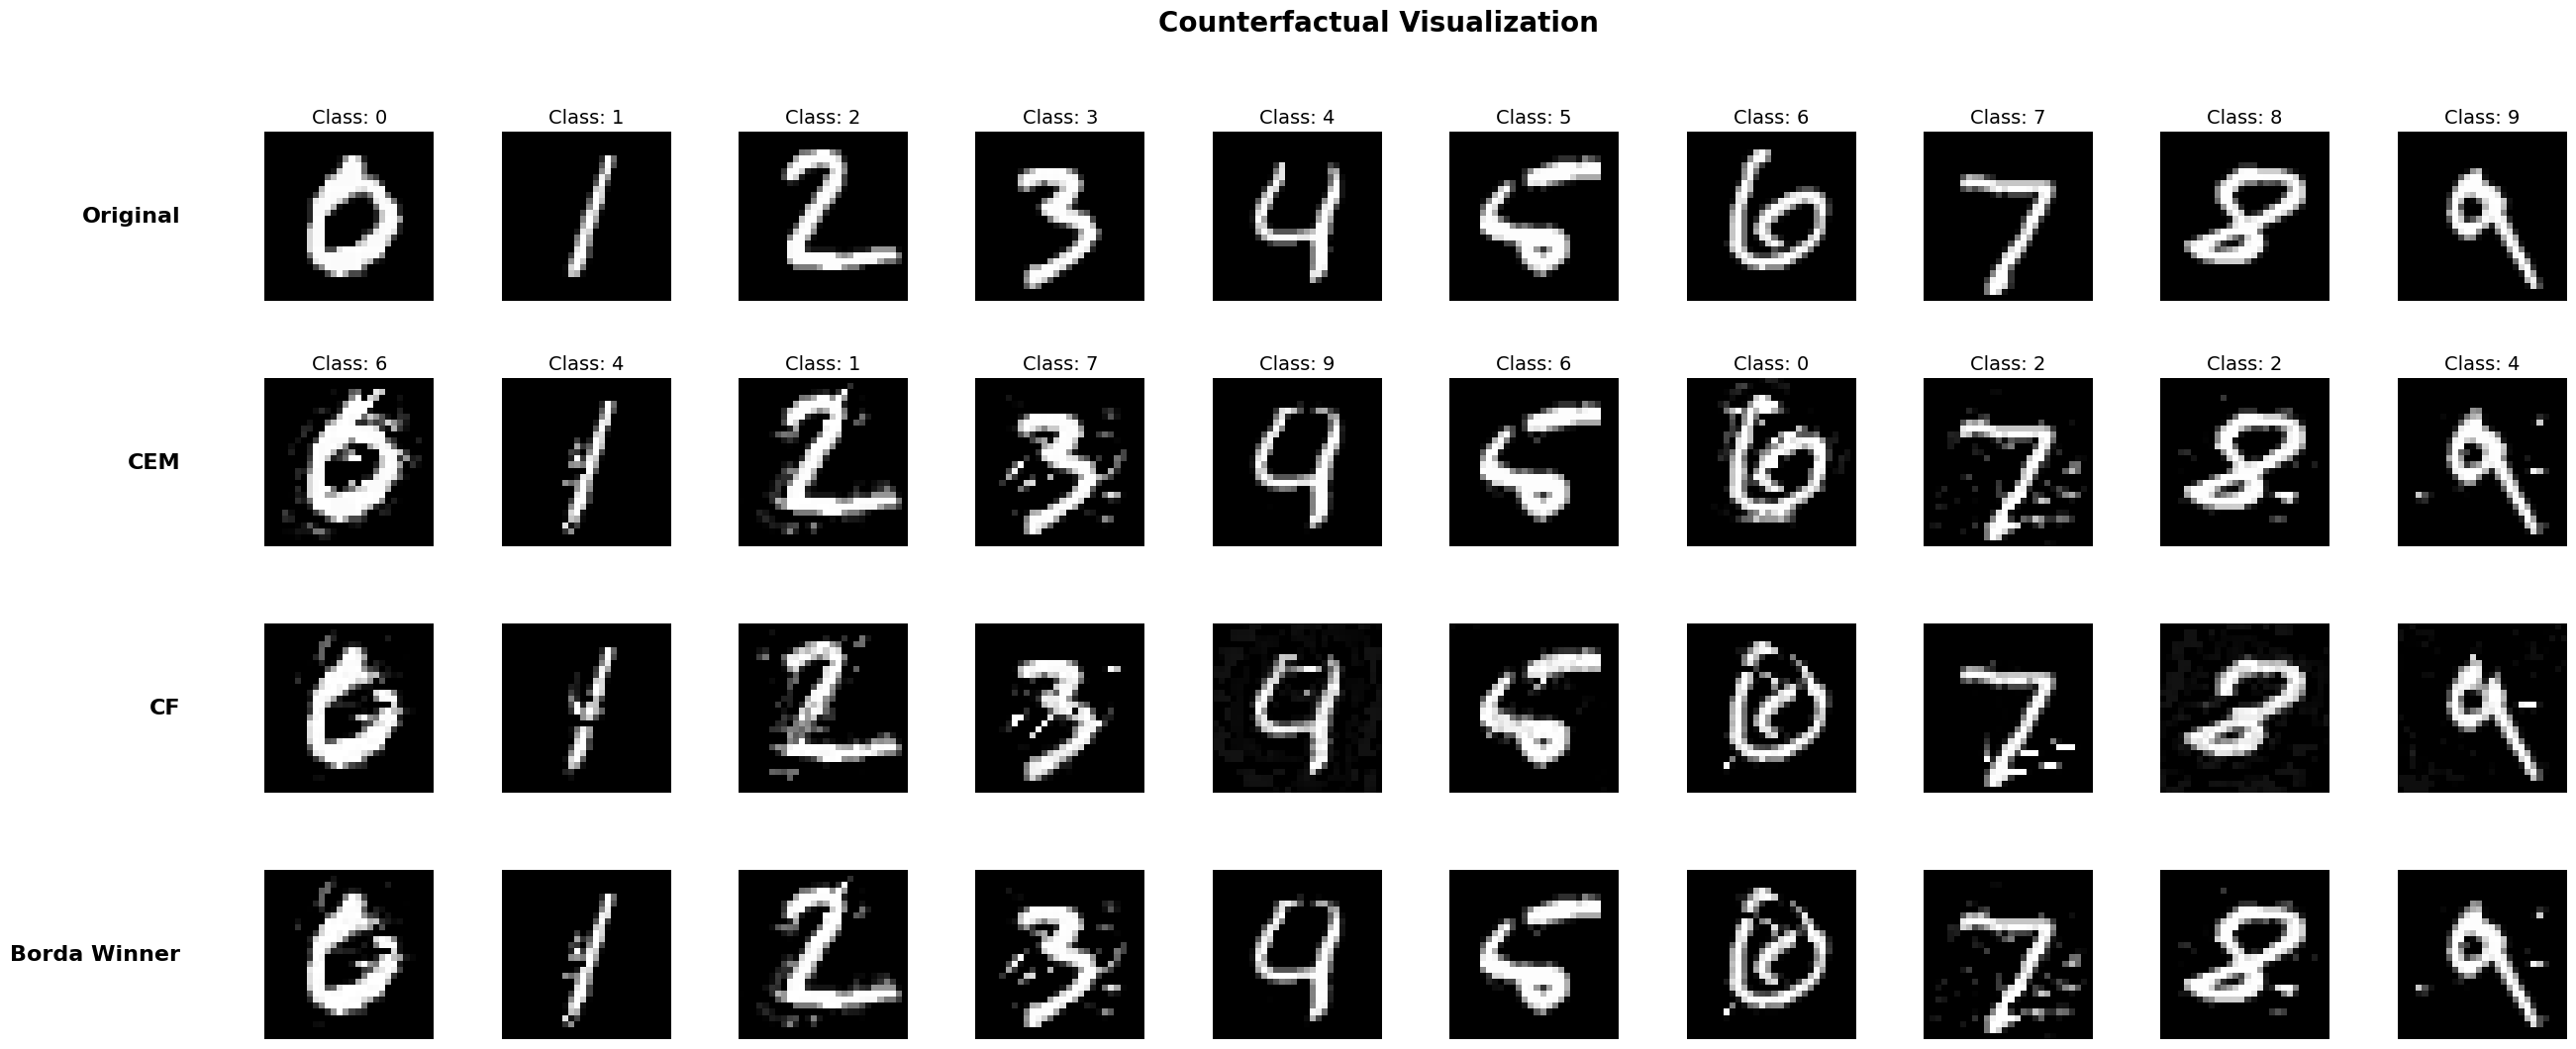

In [56]:
plot_combined_explanations(
    original_images=x_selected,                # List of 10 original images
    cem_counterfactuals=cem_counterfactuals,   # List of 10 CEM counterfactuals
    cf_counterfactuals=cf_counterfactuals,     # List of 10 CF counterfactuals
    ranked_counterfactuals=ranked_counterfactuals,  # List of 10 winning counterfactuals
    model=loaded_model,                        # Model used for predictions
    save_path="Images/Counterfactual/combined_explanations.png"      # Path to save the plot (optional)
)

In [57]:
def plot_separate_rows(
    original_images, cem_counterfactuals, cf_counterfactuals, ranked_counterfactuals, model, save_path=None
):
    """
    Visualizes each row (method) separately.

    Args:
        original_images: List or array of original images.
        cem_counterfactuals: List or array of counterfactuals generated by CEM.
        cf_counterfactuals: List or array of counterfactuals generated by CF.
        ranked_counterfactuals: List or array of counterfactuals selected by ranking.
        model: CNN model used for making predictions.
        save_path: Path to save the visualizations (optional).
    """
    # Adjust counterfactual dimensions
    cem_counterfactuals = reshape_counterfactuals(cem_counterfactuals)
    cf_counterfactuals = reshape_counterfactuals(cf_counterfactuals)

    num_images = len(original_images)  # Total number of columns
    row_data = {
        "Original": (original_images, np.argmax(model.predict(original_images), axis=1)),
        "CEM": (cem_counterfactuals, np.argmax(model.predict(cem_counterfactuals), axis=1)),
        "CF": (cf_counterfactuals, np.argmax(model.predict(cf_counterfactuals), axis=1)),
        "Winner": (ranked_counterfactuals, np.argmax(model.predict(ranked_counterfactuals), axis=1)),
    }

    for row_label, (images, preds) in row_data.items():
        print(f"Generating visualization for row: {row_label}")
        fig, axs = plt.subplots(1, num_images, figsize=(num_images * 3, 5))
        fig.suptitle(f"{row_label} Visualization", fontsize=20, fontweight="bold")

        for i in range(num_images):
            axs[i].imshow(images[i].squeeze(), cmap="gray")
            axs[i].set_title(f"Class: {preds[i]}", fontsize=14)
            axs[i].axis("off")

        # Adjust spacing between subplots
        plt.subplots_adjust(wspace=0.4)

        # Save the visualization if a path is provided
        # if save_path:
        #     save_file = f"{save_path}/{row_label.lower()}_visualization.png"
        #     print(f"Saving the {row_label} row at {save_file}")
        #     plt.savefig(save_file, bbox_inches="tight")

        # Display the visualization
        print(f"Displaying {row_label} row")
        plt.show()

Generating visualization for row: Original
Displaying Original row


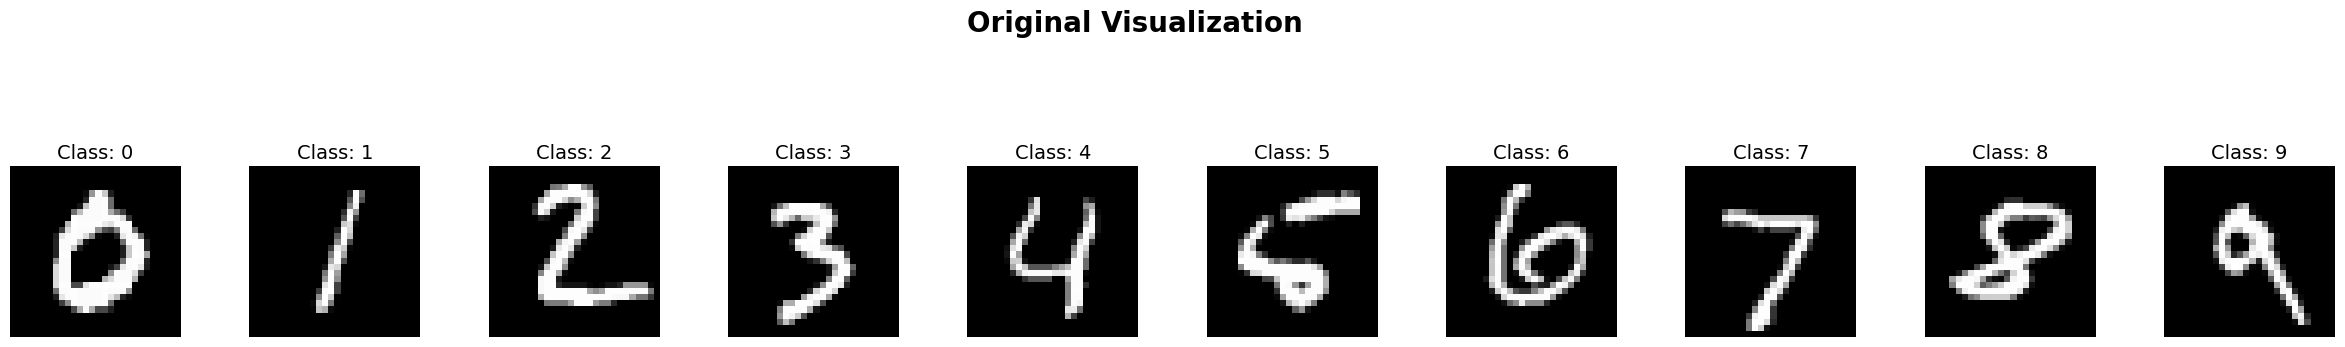

Generating visualization for row: CEM
Displaying CEM row


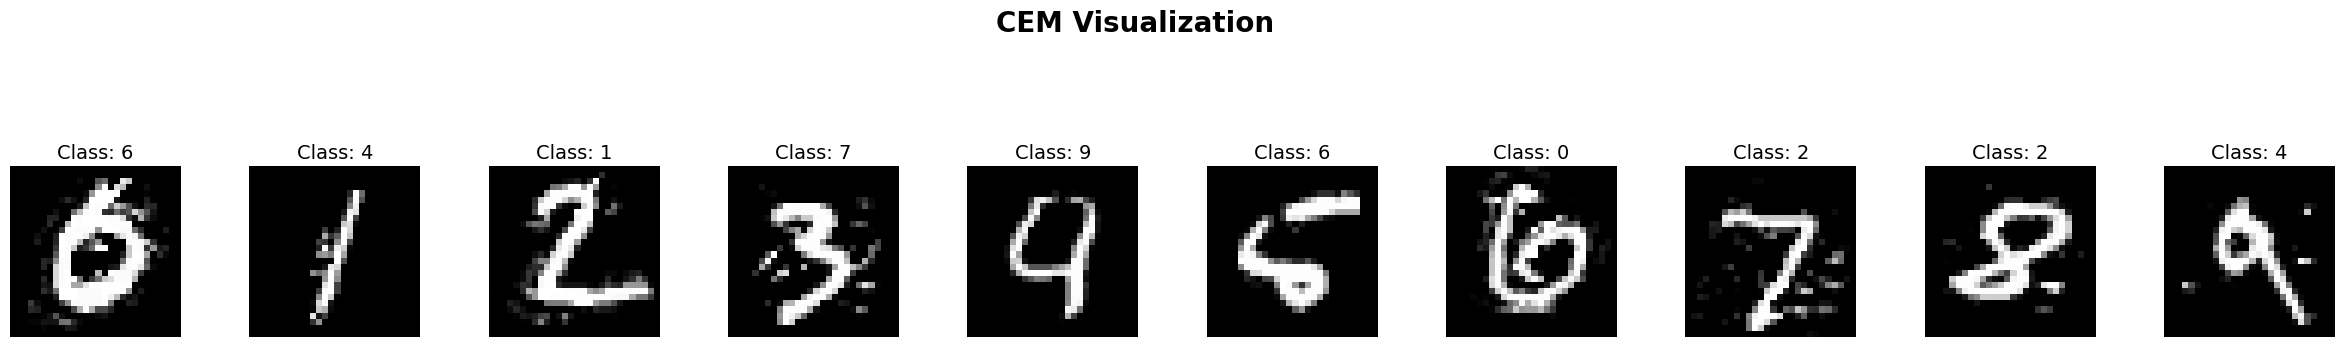

Generating visualization for row: CF
Displaying CF row


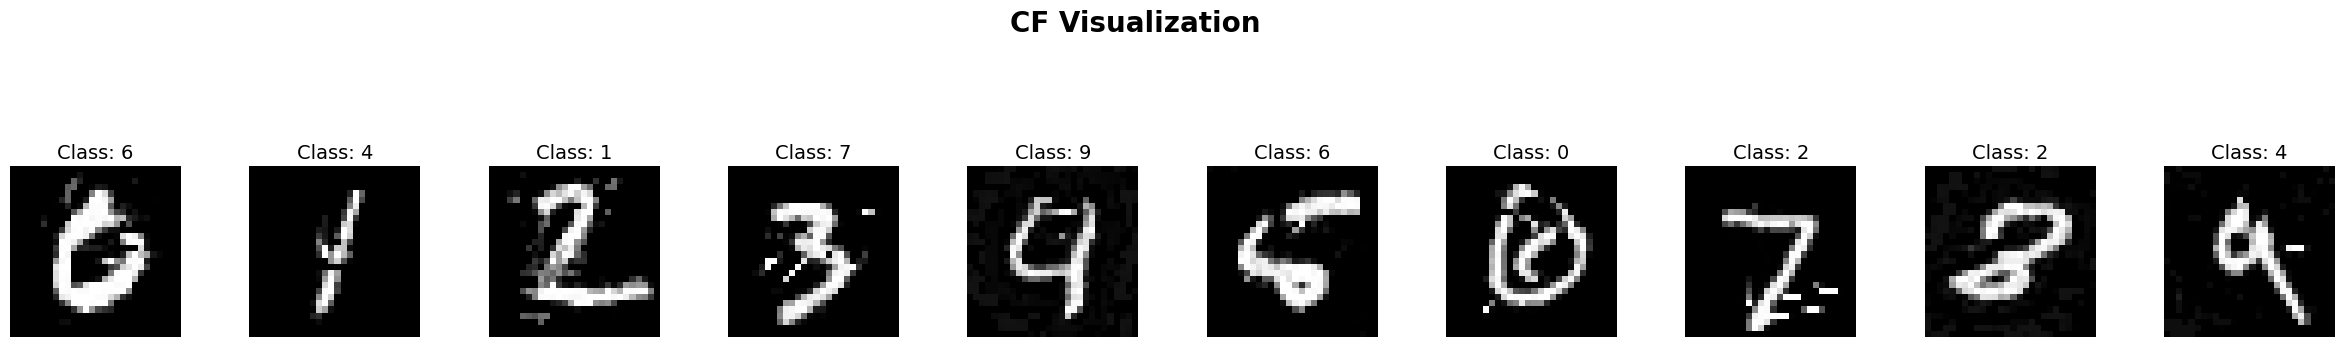

Generating visualization for row: Winner
Displaying Winner row


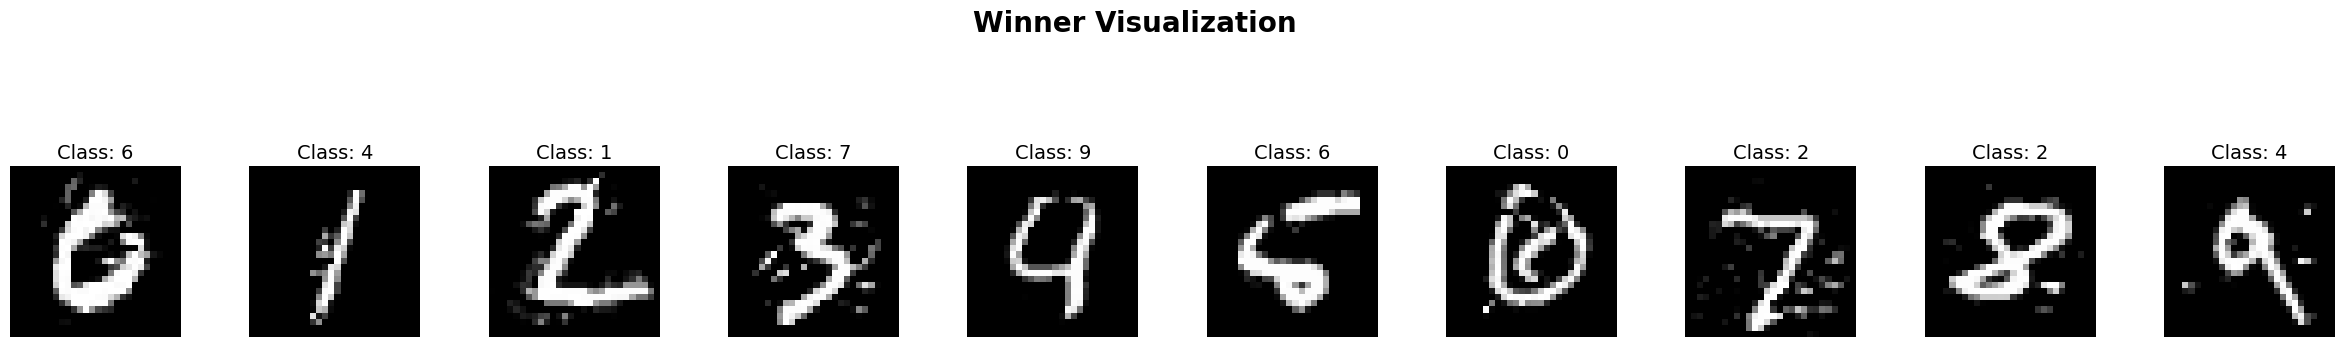

In [59]:
plot_separate_rows(
    original_images=x_selected,                # List of 10 original images
    cem_counterfactuals=cem_counterfactuals,   # List of 10 CEM counterfactuals
    cf_counterfactuals=cf_counterfactuals,     # List of 10 CF counterfactuals
    ranked_counterfactuals=ranked_counterfactuals,  # List of 10 winning counterfactuals
    model=loaded_model,                        # Model used for predictions
    save_path="Images/Counterfactual/visualizations"                 # Path to save the plots (optional)
)